#### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast   # abstract syntax trees

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay

#### Import Datasets


In [6]:
all_df= pd.read_csv('../datasets/synthetic_fraud_data.csv',)

In [4]:
all_df.shape

(7483766, 24)

In [29]:
# df= all_df.sample(frac=0.1, random_state=42)
df= all_df.sample(frac=0.3, random_state=42)
df.shape

(2245130, 24)

In [97]:
df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
543612,TX_8ab03451,CUST_45506,4276387718511132,2024-10-02 07:37:53.648473+00:00,Restaurant,casual,Red Lobster,544.43,BRL,Brazil,...,Firefox,web,3e8902e5ca8ea02f5c1cafab83b7855c,236.8.107.158,0,False,7,False,"{'num_transactions': 410, 'total_amount': 9771...",False
1940295,TX_9b278186,CUST_60434,6372131493335111,2024-10-08 01:20:04.635733+00:00,Education,online,Skillshare,1.46,CAD,Canada,...,Magnetic Stripe,pos,1703fbd0ec57fee12ffe2257dc15e3f2,119.123.124.179,1,False,1,False,"{'num_transactions': 1203, 'total_amount': 314...",True
6913787,TX_7f80b3c4,CUST_47739,6032951922681435,2024-10-28 16:04:39.625391+00:00,Entertainment,streaming,Disney+,158.73,CAD,Canada,...,Chip Reader,pos,3481722c89ab59b5ea450adfc07b55ba,105.166.250.133,0,True,16,False,"{'num_transactions': 100, 'total_amount': 3168...",True
869785,TX_7202f8a2,CUST_77691,5021869140628407,2024-10-03 15:06:36.624159+00:00,Restaurant,casual,TGI Fridays,1074.57,BRL,Brazil,...,Firefox,web,f5b0c8568cbb2c110ac396ff09baad90,196.70.93.112,0,False,15,False,"{'num_transactions': 335, 'total_amount': 6421...",False
4680413,TX_75f107d6,CUST_86097,5070103713053862,2024-10-19 10:30:45.169341+00:00,Entertainment,streaming,HBO Max,1399.64,MXN,Mexico,...,Firefox,web,c2515c6f7a3b534c8ab23d31cf57f29a,161.127.213.117,0,True,10,True,"{'num_transactions': 426, 'total_amount': 1433...",False


##### parse timestamp

In [30]:
df.timestamp= pd.to_datetime(df['timestamp'], format= 'ISO8601')

In [31]:
def modify_timestamp():
    df['year']= df.timestamp.dt.year
    df['month']= df.timestamp.dt.month
    df['day']= df.timestamp.dt.day    
    df['hour']= df.timestamp.dt.hour  # transaction_hour column already in dataset
    df['minute']= df.timestamp.dt.minute
    
    # drop timestamp as well as transaction_hour column
    df.drop(['timestamp','transaction_hour'], axis=1, inplace=True)

modify_timestamp()

#### extract velocity_last_hour
velocity_last_hour column is in str format of dictionary
- At first convert it into dictonary 
- extracting features 
- join with original dataframe and drop velocity_last_hour

all this is done using `ast (Abstract Syntax Trees)`

<pre>
import ast
ast_df= df.velocity_last_hour.apply(ast.literal_eval)  # converted string into ast trees format 
ast_df= ast_df.apply(pd.Series)  # converted into dataframe
df= df.drop(columns='velocity_last_hour').join(ast_df)  # joined with original df with velocity_last_hour dropped
df.head()
</pre>

In [32]:
# extract without creating extra variables (preseve memory)
df= df.drop(columns='velocity_last_hour').join(df.velocity_last_hour.apply(ast.literal_eval).apply(pd.Series))

##### save dataframe for faster acess

In [33]:
df.to_csv('extracted_df.csv')

In [34]:
df= pd.read_csv('extracted_df.csv', index_col= 0)
df.head(3)

,transaction_id,customer_id,card_number,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,card_present,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,weekend_transaction,is_fraud,year,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
543612,TX_8ab03451,CUST_45506,4276387718511132,Restaurant,casual,Red Lobster,544.43,BRL,Brazil,Unknown City,medium,Basic Debit,False,Firefox,web,3e8902e5ca8ea02f5c1cafab83b7855c,236.8.107.158,0,False,False,False,2024,10,2,7,37,410.0,9.771835e+06,103.0,12.0,2.076391e+06
1940295,TX_9b278186,CUST_60434,6372131493335111,Education,online,Skillshare,1.46,CAD,Canada,Unknown City,medium,Basic Credit,True,Magnetic Stripe,pos,1703fbd0ec57fee12ffe2257dc15e3f2,119.123.124.179,1,False,False,True,2024,10,8,1,20,1203.0,3.149272e+07,105.0,12.0,2.426354e+06
6913787,TX_7f80b3c4,CUST_47739,6032951922681435,Entertainment,streaming,Disney+,158.73,CAD,Canada,Unknown City,medium,Basic Debit,True,Chip Reader,pos,3481722c89ab59b5ea450adfc07b55ba,105.166.250.133,0,True,False,True,2024,10,28,16,4,100.0,3.168371e+06,62.0,11.0,8.079625e+05


In [158]:
df.isna().sum().sum()

0

#### Feature Engineering

In [264]:
df.columns

Index(['merchant_category', 'merchant_type', 'merchant', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'card_present', 'device',
       'channel', 'distance_from_home', 'high_risk_merchant',
       'transaction_hour', 'weekend_transaction', 'is_fraud',
       'num_transactions', 'total_amount', 'unique_merchants',
       'unique_countries', 'max_single_amount', 'year', 'month', 'day',
       'minute'],
      dtype='object')

In [169]:
df.select_dtypes(['int','float']).columns

Index(['card_number', 'amount', 'distance_from_home', 'transaction_hour',
       'num_transactions', 'total_amount', 'unique_merchants',
       'unique_countries', 'max_single_amount', 'year', 'month', 'day',
       'minute'],
      dtype='object')

In [37]:
df.head(2)

,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,card_present,...,is_fraud,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,year,month,day,minute
543612,Restaurant,casual,Red Lobster,544.43,BRL,Brazil,Unknown City,medium,Basic Debit,0,...,0,410.0,9.771835e+06,103.0,12.0,2.076391e+06,2024,10,2,37
1940295,Education,online,Skillshare,1.46,CAD,Canada,Unknown City,medium,Basic Credit,1,...,1,1203.0,3.149272e+07,105.0,12.0,2.426354e+06,2024,10,8,20


#### features and label

col_to_drop= ['transaction_id', 'customer_id', 'card_number', 'timestamp', 'ip_address', 'velocity_last_hour']
one_enc= ['merchant_category', 'card_type', 'device', 'channel']
ord_enc= ['city_size']
freq_enc=  ['merchant_type', 'merchant', 'device_fingerprint', 'currency', 'country','city']
label_enc= ['card_present', 'high_risk_merchant', 'weekend_transaction']

num_cols= ['dis_from_home', 'transacton_hr', 'amount']

In [36]:
col_to_drop= ['transaction_id', 'customer_id', 'card_number', 'ip_address', 'device_fingerprint' ]
one_enc= ['merchant_category', 'card_type', 'device', 'channel']
ord_enc= ['city_size']
freq_enc=  ['merchant_type', 'merchant', 'country','city'] # not to put currency later converted to usd
binary_enc= ['distance_from_home', 'card_present', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']

time_cols= ['year', 'month', 'day', 'hour', 'minute']
outlier_check= ['num_transactions', 'total_amount', 'unique_merchants', 'unique_countries', 'max_single_amount']

# dis_form home lai as it is and 
# freq_enc ra trans_hour ani amount lai matra scaling garne

In [ ]:
all_df.select_dtypes('int').columns 

Index(['card_present', 'high_risk_merchant', 'weekend_transaction',
       'is_fraud'],
      dtype='object')

In [285]:
set(df.select_dtypes(['int','float']).columns)  - set(label_enc ), freq_enc, time_cols

({'amount',
  'day',
  'distance_from_home',
  'max_single_amount',
  'minute',
  'month',
  'num_transactions',
  'total_amount',
  'transaction_hour',
  'unique_countries',
  'unique_merchants',
  'year'},
 ['merchant_type', 'merchant', 'country', 'city'],
 ['year', 'month', 'day', 'minute'])

#### feature and label

In [37]:
# encode all boolean columns as 0,1
df[binary_enc]= df[binary_enc].astype('int')

# drop unnecessary columns
df.drop(col_to_drop, axis=1, inplace=True)

X= df.drop('is_fraud', axis=1)
y= df.is_fraud

The current transaction amount is represented in its own local currency in which new feature should be generated using the standard USD

In [50]:
X.currency.unique()

array(['BRL', 'CAD', 'MXN', 'SGD', 'EUR', 'RUB', 'JPY', 'AUD', 'USD',
       'NGN', 'GBP'], dtype=object)

In [38]:
def convert_currency_amt(df):
    conversion_rates= {
        'EUR': 1.06,
        'CAD': 0.72,
        'RUB': 0.01,
        'NGN': 0.0006,
        'SGD': 0.75,
        'MXN': 0.049,
        'BRL': 0.17,
        'AUD': 0.65,
        'JPY': 0.0065
    }
    # Add a column by mapping the currency to the corresponding conversion rate,
    # defaulting to 1.28 for Great Britain Pound if currency is not in the dictionary
    df['USD_converted_amt']= df.amount * df.currency.map(conversion_rates).fillna(1.28)
    df.drop(['currency', 'amount'], axis=1, inplace= True)

    return df

X= convert_currency_amt(X)

In [39]:
outlier_check.append('USD_converted_amt')

#### train test split

In [40]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state=42)

In [41]:
X_train[:2]

,merchant_category,merchant_type,merchant,country,city,city_size,card_type,card_present,device,channel,...,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,year,month,day,minute,USD_converted_amt
234181,Retail,online,AliExpress,Germany,Unknown City,medium,Basic Debit,0,Android App,mobile,...,3486.0,8.615629e+07,105.0,12.0,988918.795670,2024,9,30,16,417.3750
6315225,Healthcare,medical,Urgent Care,Singapore,Unknown City,medium,Basic Credit,0,Safari,web,...,67.0,4.075023e+05,48.0,10.0,217975.132575,2024,10,26,38,300.7575


#### frequency encoding

In [41]:
# frequency encoding
all_freq_map= {}
for col in freq_enc:
    freq_map= X_train[col].value_counts().to_dict()
    all_freq_map[col]= freq_map     # save to all_freq_map  and dump later 
    X_train[col]= X_train[col].map(freq_map)
    
    # replace Nan with minimum value (for unseen data)    
    X_test[col]= X_test[col].map(freq_map).fillna(min(freq_map.values()))    

In [45]:
X_train[:2]

,merchant_category,merchant_type,merchant,country,city,city_size,card_type,card_present,device,channel,distance_from_home,high_risk_merchant,weekend_transaction,year,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
234181,Retail,336902,16135,126057,1676288,medium,Basic Debit,0,Android App,mobile,0,0,0,2024,9,30,23,16,3486.0,8.615629e+07,105.0,12.0,988918.795670,417.3750
6315225,Healthcare,112271,28218,141478,1676288,medium,Basic Credit,0,Safari,web,0,0,1,2024,10,26,4,38,67.0,4.075023e+05,48.0,10.0,217975.132575,300.7575


#### visualize datasets

In [15]:
pd.options.display.float_format= "{:.2f}".format
X_train.describe()

,merchant_type,merchant,amount,currency,country,city,card_present,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction
count,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00,1796104.00
mean,151924.58,20262.23,48172.96,174754.60,156543.36,1565264.13,0.09,0.32,0.25,12.15,0.26
std,100976.54,8659.57,179280.87,45629.42,33583.03,415272.72,0.28,0.47,0.43,6.54,0.44
min,55794.00,9215.00,0.01,119377.00,119377.00,11810.00,0.00,0.00,0.00,0.00,0.00
25%,74804.00,14153.00,364.38,127279.00,126281.00,1676288.00,0.00,0.00,0.00,7.00,0.00
50%,111930.00,16169.00,1180.24,187863.00,141478.00,1676288.00,0.00,0.00,0.00,12.00,0.00
75%,224166.00,27978.00,22452.72,204227.00,190646.00,1676288.00,0.00,1.00,1.00,18.00,1.00
max,336902.00,37522.00,6243212.03,255797.00,204227.00,1676288.00,1.00,1.00,1.00,23.00,1.00


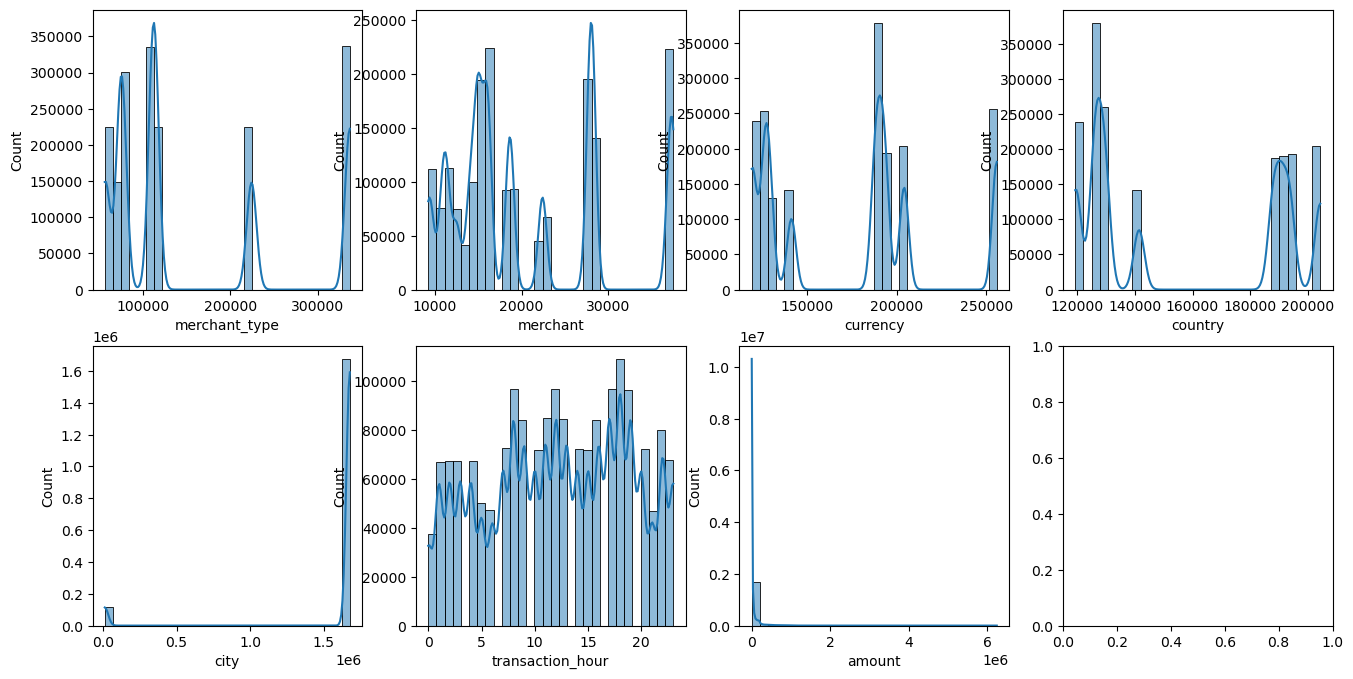

In [29]:
import seaborn as sns
rows= 2
cols= -(- len(col_to_scale) // rows) #  -(-7/3) == 3 fl0or lower to -3 then make it 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))  # 1 row, 2 columns

for i in range(rows):
    for j in range(cols):
        if (i+1) * (j+1) < len(col_to_scale):
            col= col_to_scale[i * cols + j]
            sns.histplot(X_train[col], kde=True, bins=30, ax= axes[i][j])
            # axes[i][j].set_title(f"Distribution of {col}")


In [13]:
X_train.transaction_hour.unique()

array([23,  4, 13,  3, 19, 11, 14, 18, 10,  5,  8, 22, 16, 15,  1,  2, 12,
        9,  6,  7, 21,  0, 20, 17], dtype=int64)

<Axes: ylabel='transaction_hour'>

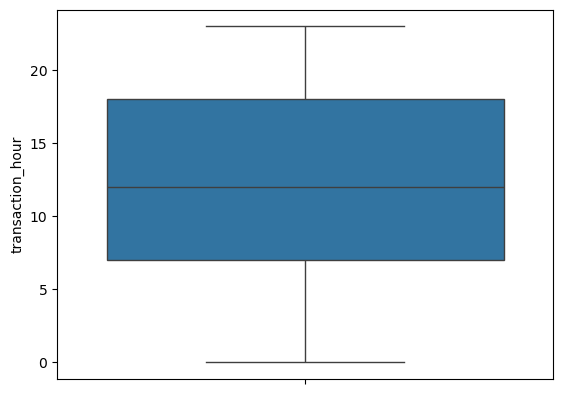

In [ ]:
sns.boxplot(X_train.transaction_hour)

#### analysis dataset

In [16]:
all_df.velocity_last_hour.unique()

7483740

In [18]:
all_df.velocity_last_hour.value_counts()

velocity_last_hour
{'num_transactions': 0, 'total_amount': 371.88, 'unique_merchants': 0, 'unique_countries': 0, 'max_single_amount': 371.88}                                 3
{'num_transactions': 0, 'total_amount': 245.89, 'unique_merchants': 0, 'unique_countries': 0, 'max_single_amount': 245.89}                                 2
{'num_transactions': 0, 'total_amount': 407.91, 'unique_merchants': 0, 'unique_countries': 0, 'max_single_amount': 407.91}                                 2
{'num_transactions': 0, 'total_amount': 469.53, 'unique_merchants': 0, 'unique_countries': 0, 'max_single_amount': 469.53}                                 2
{'num_transactions': 0, 'total_amount': 214.5, 'unique_merchants': 0, 'unique_countries': 0, 'max_single_amount': 214.5}                                   2
                                                                                                                                                          ..
{'num_transactions': 286, 'total_amount

In [22]:
all_df.columns
    

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'merchant_category', 'merchant_type', 'merchant', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'card_present', 'device',
       'channel', 'device_fingerprint', 'ip_address', 'distance_from_home',
       'high_risk_merchant', 'transaction_hour', 'weekend_transaction',
       'velocity_last_hour', 'is_fraud'],
      dtype='object')

In [23]:
all_df.merchant.value_counts()

merchant
Chegg                   156105
Highway Gas Stop        155980
Local Gas Station       155977
Truck Stop              155945
University Bookstore    155827
                         ...  
Delta                    38935
JetBlue                  38934
Holiday Inn              38888
American Airlines        38801
Emirates                 38623
Name: count, Length: 105, dtype: int64

In [25]:
all_df.merchant_type.value_counts()

merchant_type
online       1401650
physical      935039
medical       468393
pharmacy      468377
local         467902
major         467499
supplies      466765
fast_food     312805
events        312598
streaming     312091
premium       311695
casual        311678
gaming        311484
hotels        234311
booking       234026
transport     233977
airlines      233476
Name: count, dtype: int64

In [27]:
len(all_df.merchant_category.value_counts()), len(all_df.merchant_type.value_counts()), len(all_df.merchant.value_counts()),

(8, 17, 105)

In [43]:
all_df.groupby(['merchant_category', 'merchant_type'])[['merchant']].nunique()

merchant
merchant_category merchant_type          
Education         online                5
                  supplies              3
Entertainment     events                5
                  gaming                5
                  streaming             7
Gas               local                 3
                  major                 6
Grocery           online                4
                  physical              7
Healthcare        medical               4
                  pharmacy              4
Restaurant        casual                5
                  fast_food             6
                  premium               4
Retail            online                7
                  physical              8
Travel            airlines              6
                  booking               5
                  hotels                6
                  transport             5

In [46]:
all_df[:1000].groupby(['merchant_category','merchant_type','merchant'])[['merchant']].count()

merchant
merchant_category merchant_type merchant                       
Education         online        Coursera                     15
                                MasterClass                  16
                                Skillshare                    8
                                Udemy                        16
                                edX                          13
...                                                         ...
Travel            transport     Careem                        5
                                Enterprise Rent-A-Car         3
                                Hertz                         6
                                Lyft                          7
                                Uber                         11

[105 rows x 1 columns]

In [45]:
all_df[all_df['merchant_category'] == 'Education'].merchant.value_counts()

merchant
Chegg                   156105
University Bookstore    155827
Barnes & Noble          154833
Udemy                    93511
MasterClass              93405
edX                      93315
Skillshare               93285
Coursera                 93261
Name: count, dtype: int64

In [54]:
X_train.describe()

,merchant_type,merchant,amount,currency,country,city,card_present,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction
count,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06
mean,1.519246e+05,2.026223e+04,4.817296e+04,1.747546e+05,1.565434e+05,1.565264e+06,8.685243e-02,3.216696e-01,2.509476e-01,1.214997e+01,2.572368e-01
std,1.009765e+05,8.659574e+03,1.792809e+05,4.562942e+04,3.358303e+04,4.152727e+05,2.816188e-01,4.671171e-01,4.335585e-01,6.538745e+00,4.371111e-01
min,5.579400e+04,9.215000e+03,1.000000e-02,1.193770e+05,1.193770e+05,1.181000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.480400e+04,1.415300e+04,3.643775e+02,1.272790e+05,1.262810e+05,1.676288e+06,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00
50%,1.119300e+05,1.616900e+04,1.180240e+03,1.878630e+05,1.414780e+05,1.676288e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01,0.000000e+00
75%,2.241660e+05,2.797800e+04,2.245272e+04,2.042270e+05,1.906460e+05,1.676288e+06,0.000000e+00,1.000000e+00,1.000000e+00,1.800000e+01,1.000000e+00
max,3.369020e+05,3.752200e+04,6.243212e+06,2.557970e+05,2.042270e+05,1.676288e+06,1.000000e+00,1.000000e+00,1.000000e+00,2.300000e+01,1.000000e+00


none of the above graphs seems to be normally distributed. 
- Thus Standard Scaler is not suitable

Check min and max values

- If the max value is significantly higher than Q3 → Possible high outlier
- If the min value is significantly lower than Q1 → Possible low outlier

#### check for outliers

In [42]:
outlier_check

['num_transactions',
 'total_amount',
 'unique_merchants',
 'unique_countries',
 'max_single_amount',
 'USD_converted_amt']

In [46]:
X_train[outlier_check].describe()

,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
count,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06,1.796104e+06
mean,4.092501e+02,1.994606e+07,8.004026e+01,1.066438e+01,1.725602e+06,5.381818e+02
std,3.914524e+02,3.572035e+07,3.045538e+01,2.615385e+00,1.397091e+06,7.189875e+02
min,0.000000e+00,1.454232e-02,0.000000e+00,0.000000e+00,1.454232e-02,2.412000e-03
25%,1.060000e+02,3.374443e+06,6.400000e+01,1.100000e+01,8.016779e+05,1.663488e+02
50%,2.920000e+02,1.016920e+07,9.500000e+01,1.200000e+01,1.234100e+06,3.538550e+02
75%,6.060000e+02,2.274057e+07,1.040000e+02,1.200000e+01,2.290390e+06,6.199808e+02
max,3.854000e+03,1.046462e+09,1.050000e+02,1.200000e+01,6.253153e+06,1.827724e+04


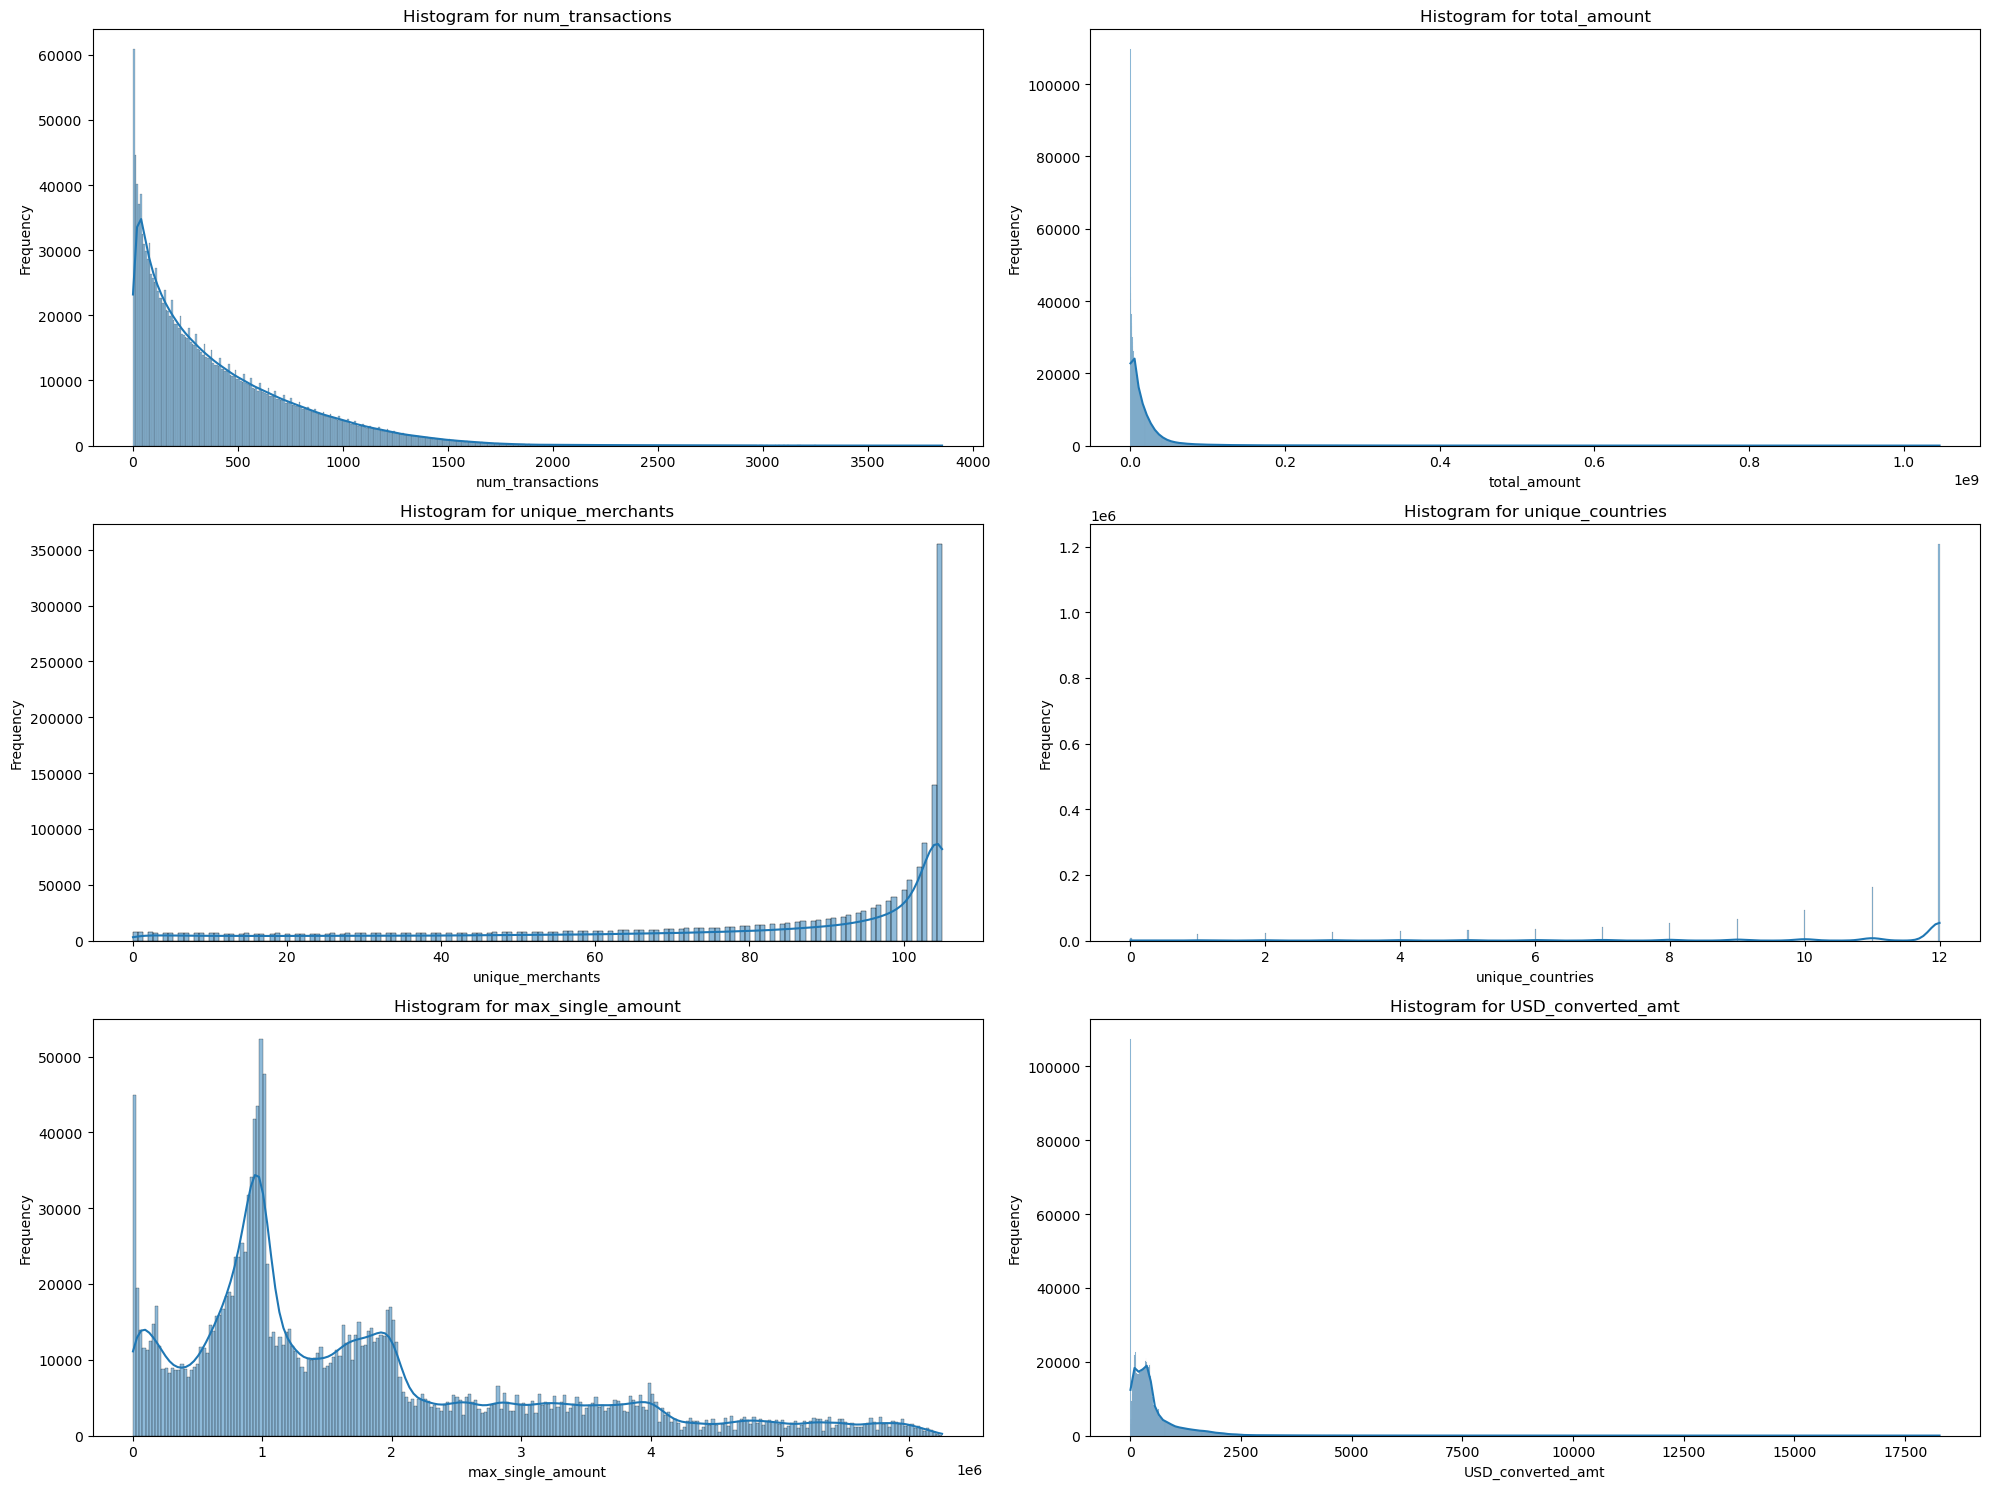

In [47]:
ncol= 2
nrow= -(-len(outlier_check) // ncol)

import seaborn as sns
fig, axes= plt.subplots(nrow, ncol, figsize= (20,15))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.histplot(X_train[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

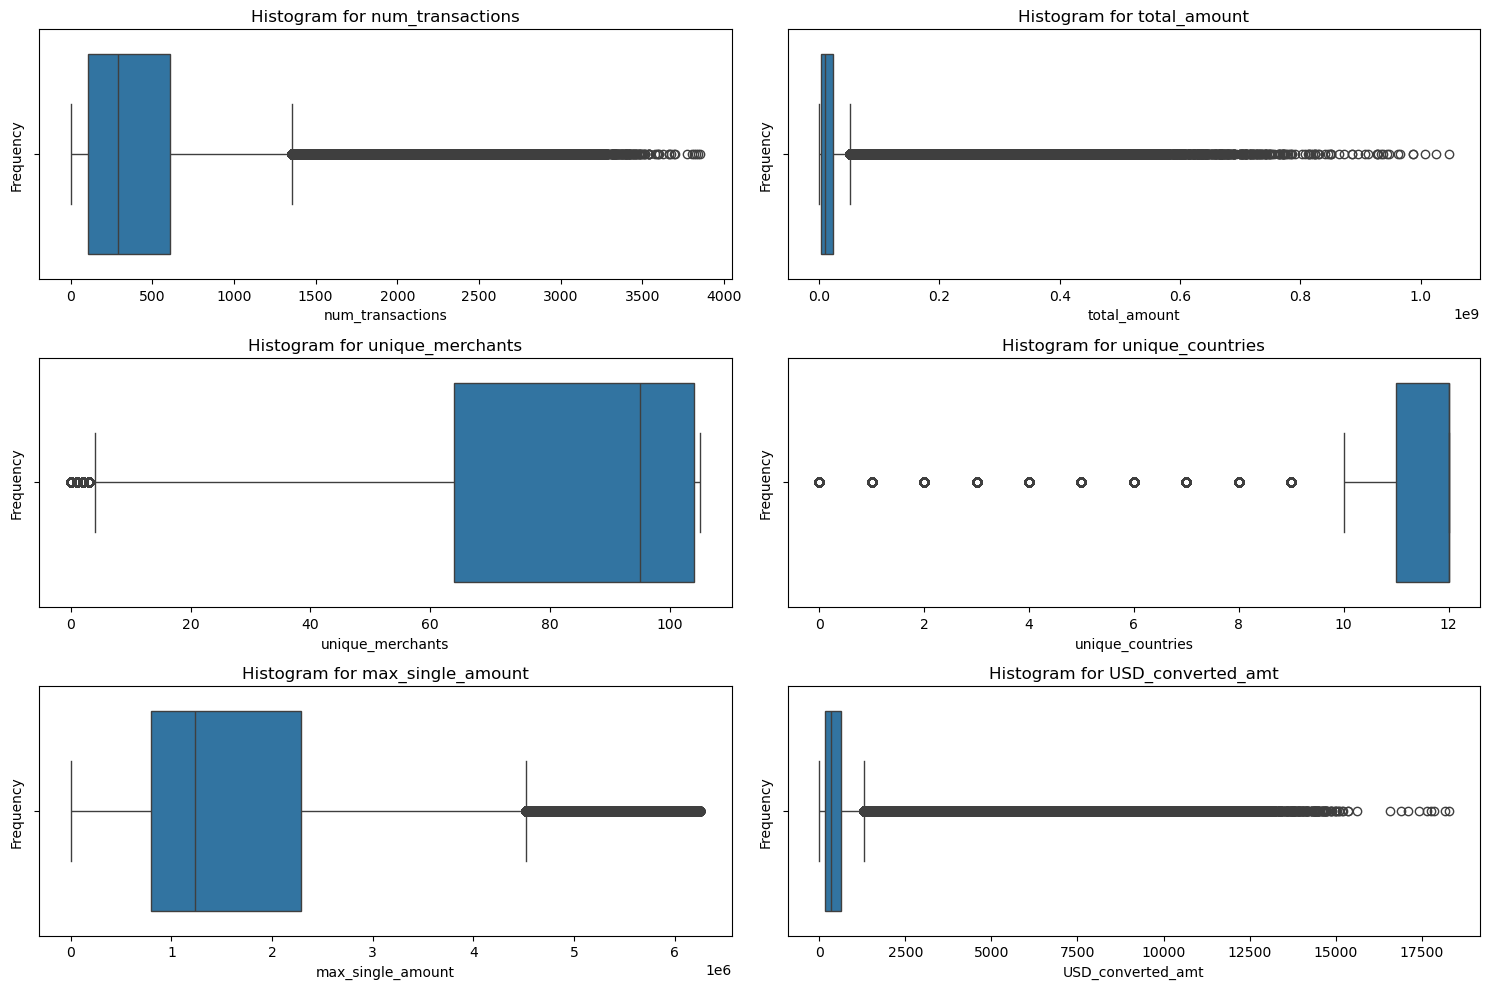

In [48]:
fig, axes= plt.subplots(nrow, ncol, figsize= (15,10))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.boxplot(data=X_train, x=col, ax=axes[i])
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [49]:
def check_outliers(df, cols_to_check):
    for col in cols_to_check:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        outlier_count = len(df[(df[col] > upper) | (df[col] < lower)])
        print(f'Outlier Count for {col} : {outlier_count}')

In [50]:
check_outliers(X_train, outlier_check)

Outlier Count for num_transactions : 49282
Outlier Count for total_amount : 133130
Outlier Count for unique_merchants : 29704
Outlier Count for unique_countries : 333368
Outlier Count for max_single_amount : 110319
Outlier Count for USD_converted_amt : 169206


Since there are many outliers best to use robust scaling or remove outliers and use minmax scaling

removing outliers would not affect the prediction by a lot. Nevertheless, taking the result of histogram also into apart, the data should rather go through MinMaxScaler to reduce the impact of outliers

In [51]:
# removing outliers 
Q1= X_train[outlier_check].quantile(0.25)
Q3= X_train[outlier_check].quantile(0.75)
IQR= Q3 - Q1

# Define lower and upper bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create a boolean mask for rows to keep
mask= ~((X_train[outlier_check] < lower) | (X_train[outlier_check] > upper)).any(axis=1)

X_train_clean= X_train[mask]
y_train_clean= y_train[mask]

In [52]:
X_train.shape, X_train_clean.shape

((1796104, 24), (1113990, 24))

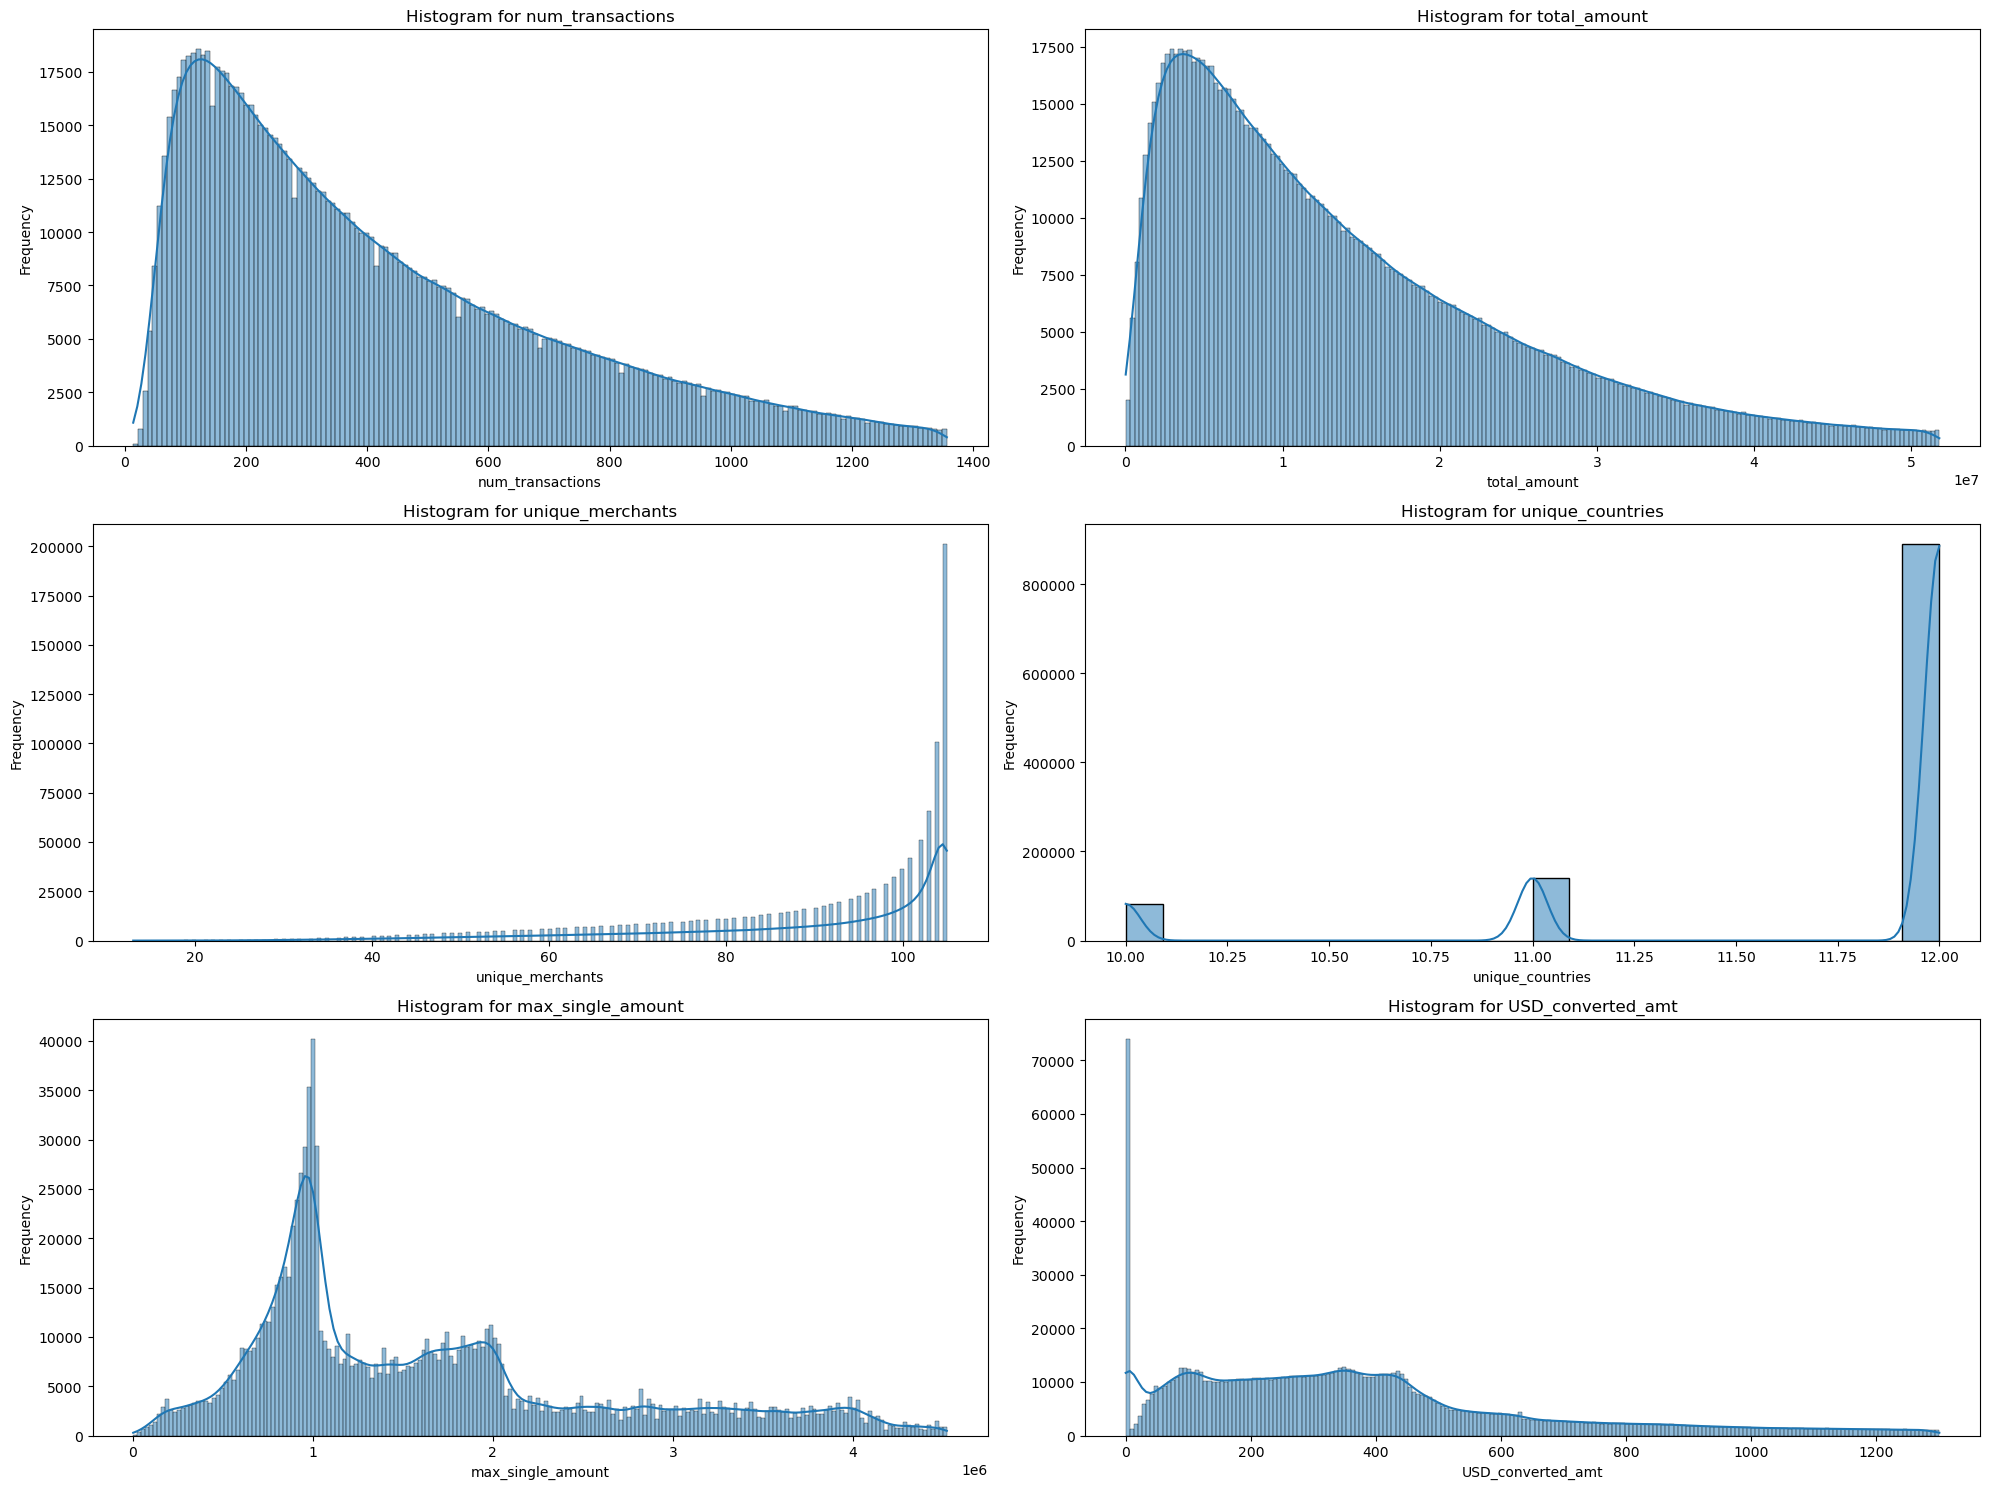

In [53]:
fig, axes= plt.subplots(nrow, ncol, figsize= (20,15))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.histplot(X_train_clean[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

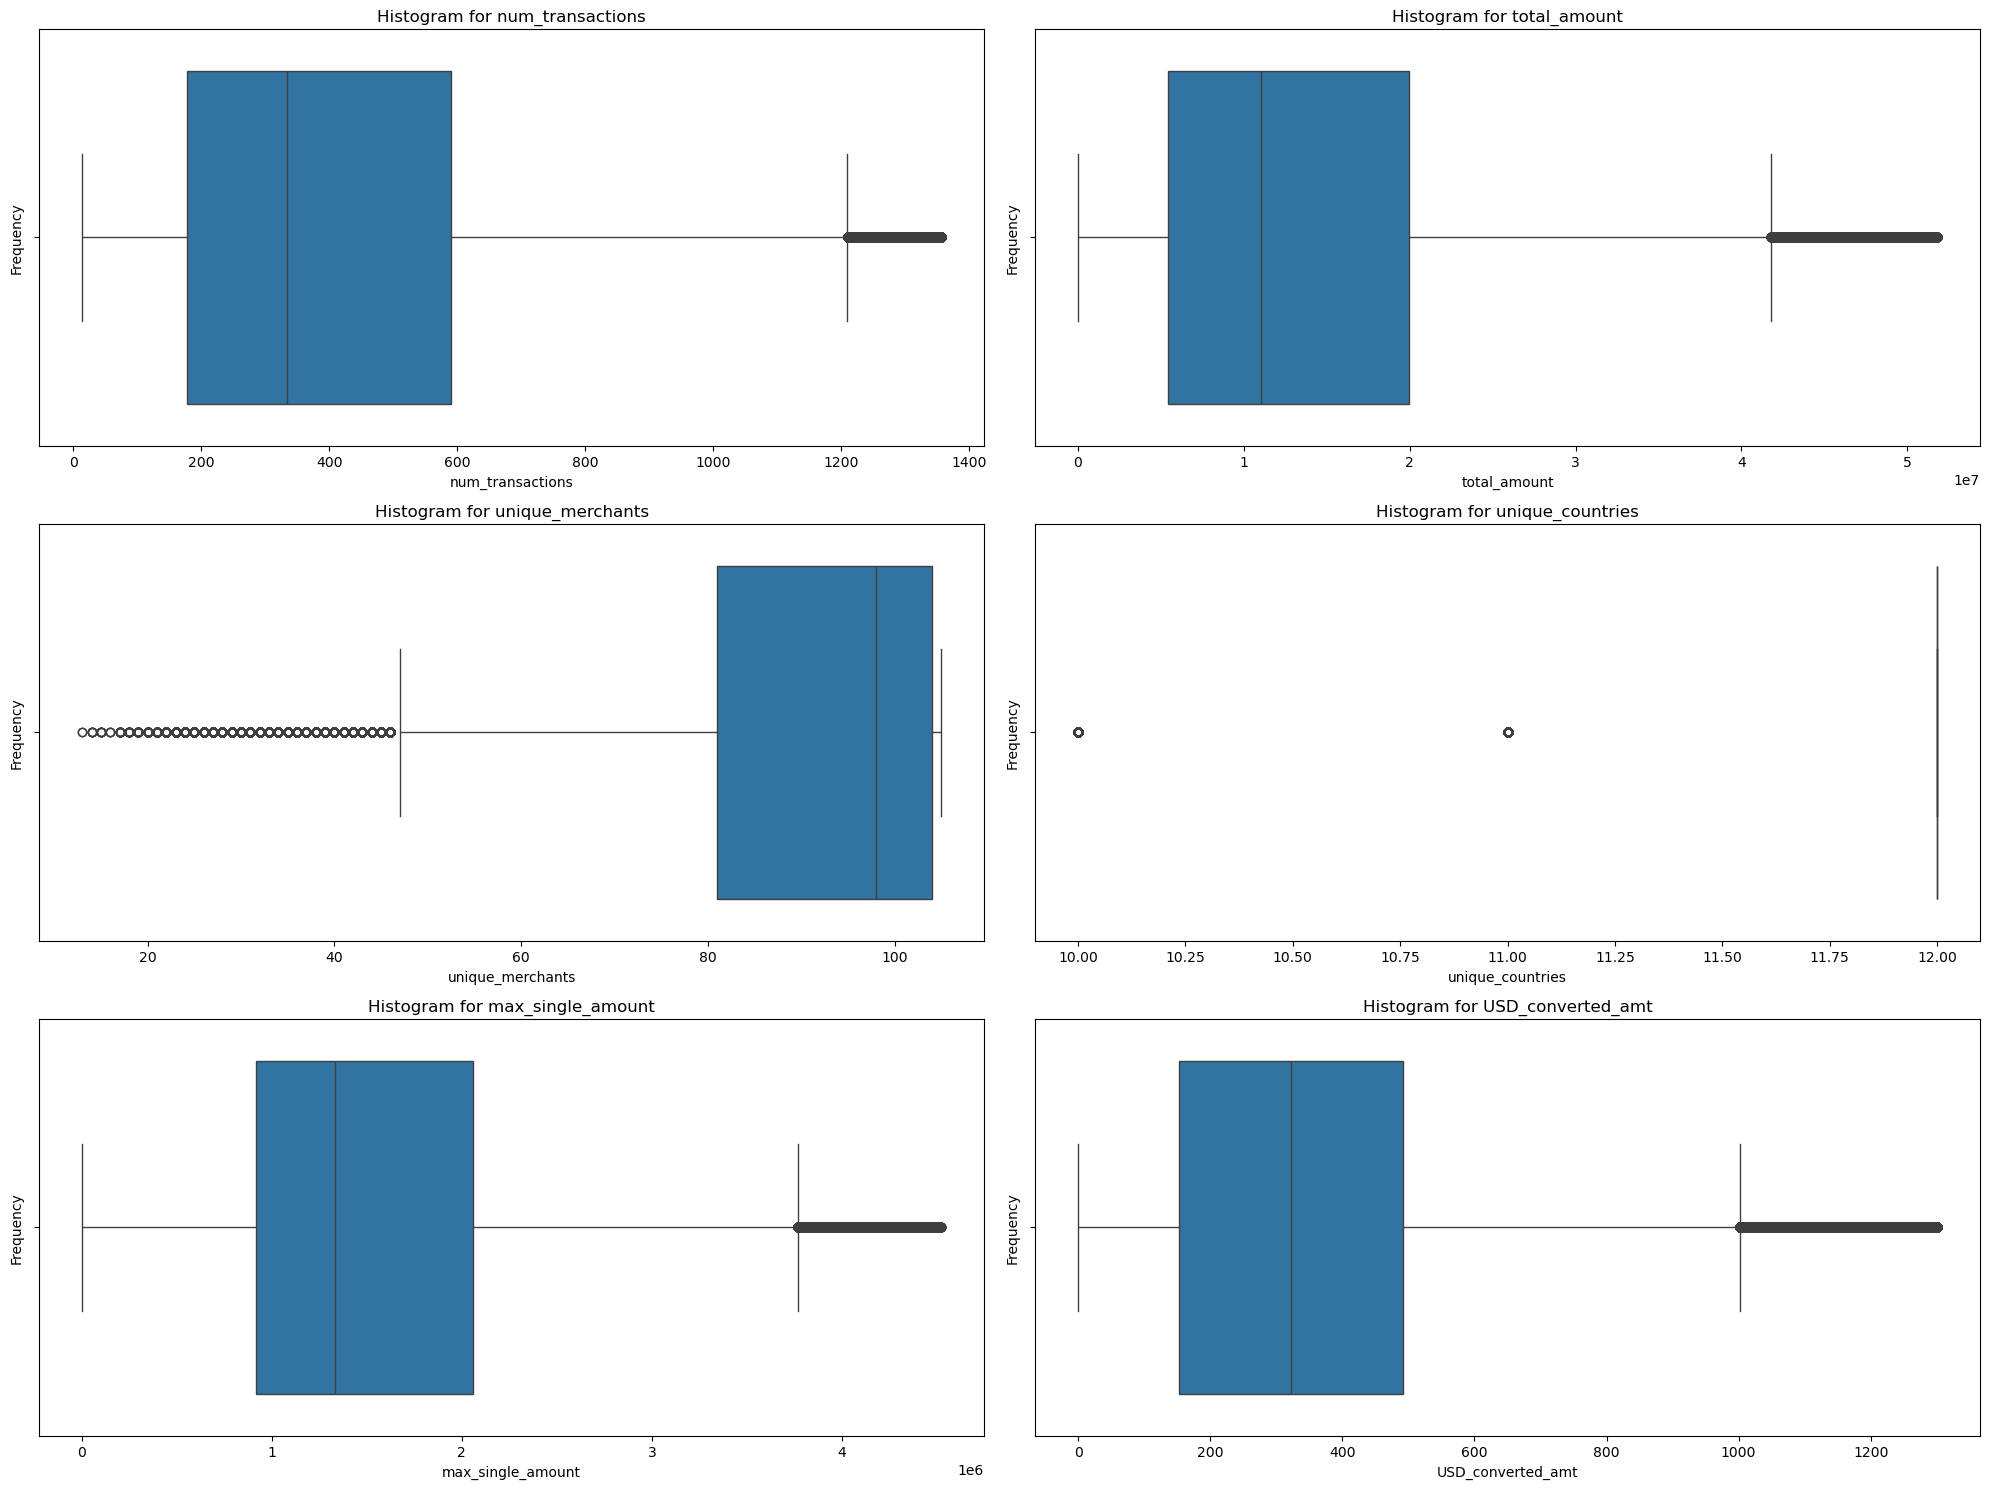

In [54]:
fig, axes= plt.subplots(nrow, ncol, figsize= (20,15))
axes= axes.flatten()  # flatten for easier indexing
for i, col in enumerate(outlier_check):  # with indexing
    sns.boxplot(data=X_train_clean, x=col, ax=axes[i])
    axes[i].set_title(f'Histogram for {col}')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [55]:
X_train= X_train_clean
y_train= y_train_clean

#### feature encoding

In [57]:
col_to_scale = freq_enc + time_cols + outlier_check
col_to_scale

['merchant_type',
 'merchant',
 'country',
 'city',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'num_transactions',
 'total_amount',
 'unique_merchants',
 'unique_countries',
 'max_single_amount',
 'USD_converted_amt']

In [58]:
ct= ColumnTransformer(transformers=[
    ('one-hot', OneHotEncoder(), one_enc),
    ('ordinal', OrdinalEncoder(categories= [['medium', 'large']]), ord_enc)
], remainder='passthrough')

# data contains outlier
# rb= RobustScaler()
ms= MinMaxScaler()

# standardarize 
X_train[col_to_scale]= ms.fit_transform(X_train[col_to_scale])  # only numeric and frequency encoded columns only 
X_test[col_to_scale]= ms.transform(X_test[col_to_scale])

# encode features
X_train_enc= ct.fit_transform(X_train)
X_test_enc= ct.transform(X_test)

# encode label 
# y_train_enc= le.fit_transform(y_train)  no need already converted to 0/1
# y_test_enc= le.transform(y_test)


#### get feature names

In [59]:
# Get feature names after transformation
feature_names = (ct.named_transformers_['one-hot'].get_feature_names_out(one_enc).tolist() + 
                ['city_size'] + 
                [col for col in X.columns if col not in one_enc + ord_enc])

X_train_enc= pd.DataFrame(data=X_train_enc, columns=feature_names)
X_test_enc= pd.DataFrame(data=X_test_enc, columns=feature_names)

#### Build a model

In [60]:
model= LogisticRegression()
model.fit(X_train_enc, y_train)
model.score(X_train_enc, y_train), model.score(X_test_enc, y_test)

(0.9329329706729863, 0.9248105900326484)

In [61]:
df.is_fraud.value_counts()/ len(df)

is_fraud
0    0.800515
1    0.199485
Name: count, dtype: float64

on frac= 0.6
- when scaling is applied : (0.9239203297804581, 0.9243863384302914)
- not applied : (0.8277196086640862, 0.8277983902936579)
- only applied on num_cols: (0.8995481330702454, 0.8996672798457105)

##### on frac = 0.3
using robust scalar: (max_iter limit warning)
- on both freq + num: (0.9192368593355396, 0.9191104746718453) (0.9242805539100186, 0.923420915492644) max_iter: 1000
- max_iter:100 (default)  (0.8154010012783224, 0.8147100613327514)

using min-max scaling
- (0.9241797802354429, 0.9233719205569388) default-> max_iter:100

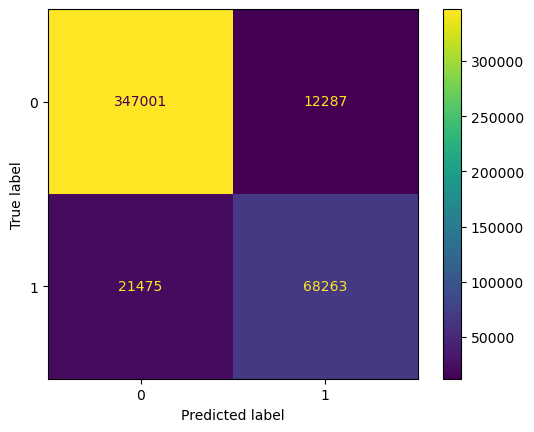

In [62]:
y_pred= model.predict(X_test_enc)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()

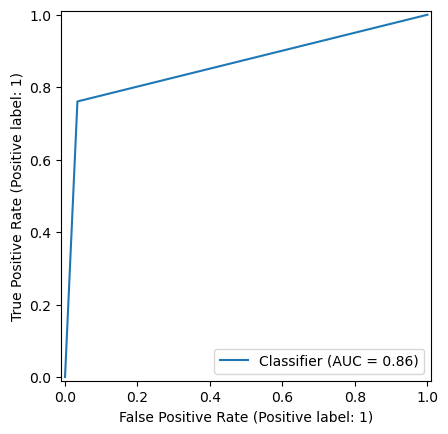

In [63]:
RocCurveDisplay.from_predictions(y_test, y_pred)

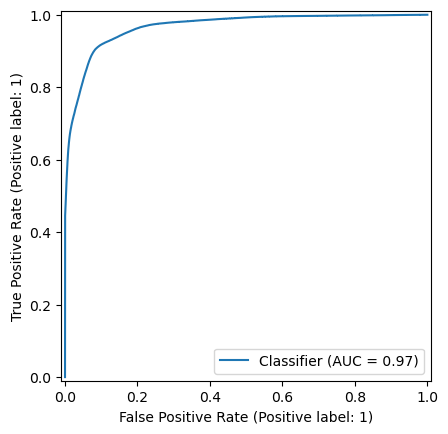

In [64]:
RocCurveDisplay.from_predictions(y_test, model.predict_proba(X_test_enc)[:,1])      # with respect to tpr (true positive)/ fraud

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    359288
           1       0.85      0.76      0.80     89738

    accuracy                           0.92    449026
   macro avg       0.89      0.86      0.88    449026
weighted avg       0.92      0.92      0.92    449026



#### traing model with balanced model
- using class_weights='balance' as hyperparameter ()
- using RandomOverSample (duplicates the minority class)
- SMOTE (Synthetic Minority Over-sampling Technique) - generating synthetic samples of the minority class, thus balancing the dataset and potentially improving model performance. 

In [66]:
model_2= LogisticRegression(class_weight='balanced')
model_2.fit(X_train_enc, y_train)
model_2.score(X_train_enc, y_train), model_2.score(X_test_enc, y_test)

(0.9109426476000683, 0.9064731218236806)

In [67]:
print(classification_report(y_test, model.predict(X_test_enc))), print(classification_report(y_test, model_2.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    359288
           1       0.85      0.76      0.80     89738

    accuracy                           0.92    449026
   macro avg       0.89      0.86      0.88    449026
weighted avg       0.92      0.92      0.92    449026

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    359288
           1       0.71      0.91      0.80     89738

    accuracy                           0.91    449026
   macro avg       0.84      0.91      0.87    449026
weighted avg       0.92      0.91      0.91    449026



(None, None)

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1bae74f68d0>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1ba6a021400>)

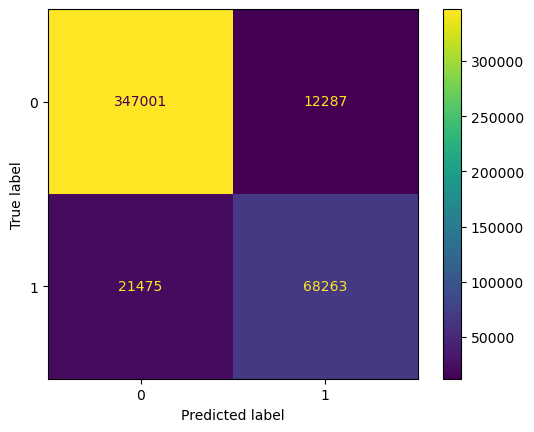

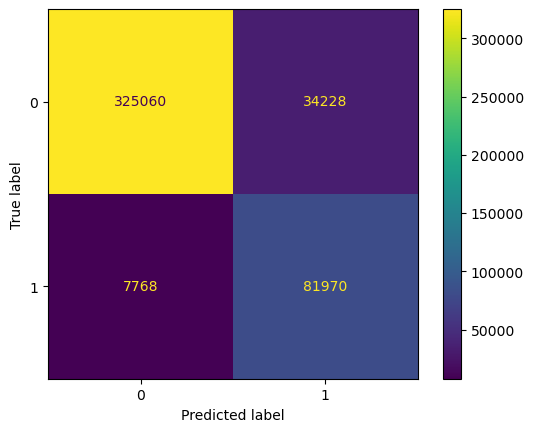

In [68]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model.predict(X_test_enc))).plot(), ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model_2.predict(X_test_enc))).plot()

#### save the model

as well as encoders

In [31]:
import joblib
import os

# Ensure the directory exists
os.makedirs("./models/encoders", exist_ok=True)
# dump model
joblib.dump(model, './models/model.pkl')

joblib.dump(ct, './models/encoders/col_transformer.pkl')
joblib.dump(sc, './models/encoders/scaler.pkl')

# save freq_map for frequency encoder
joblib.dump(all_freq_map, './models/encoders/all_freq_map.pkl')

# save features names (during training)
joblib.dump(feature_names, './models/feature_names.pkl')

['./models/feature_names.pkl']

#### Feature Importance

In [54]:
model.coef_

array([[-1.15958328e-01, -7.18112467e-02, -2.46250874e-01,
        -1.30302801e-01, -2.59624336e-01, -4.16086390e-01,
        -2.73164495e-01, -2.37757752e-01, -3.54348719e-01,
        -3.33609495e-01, -3.23780211e-01, -3.95792002e-01,
        -3.43423470e-01, -8.90338920e-01,  7.49601199e-01,
        -5.44146063e-01, -6.20825668e-01, -5.04072976e-01,
         7.44261970e-01,  7.38548364e-01, -5.02235224e-01,
        -9.21741127e-01, -1.81208316e+00,  2.23240893e+00,
        -2.17128438e+00, -9.59151673e-03, -1.44874280e-01,
        -1.31468923e-01,  2.99169506e-02, -5.37688821e-02,
         1.80066736e+00, -7.62597014e-08,  2.23240893e+00,
         4.00380637e+00, -3.09567759e-01, -1.17239582e+00,
         1.66835576e-02]])

feature importance with top 20 features

<Axes: >

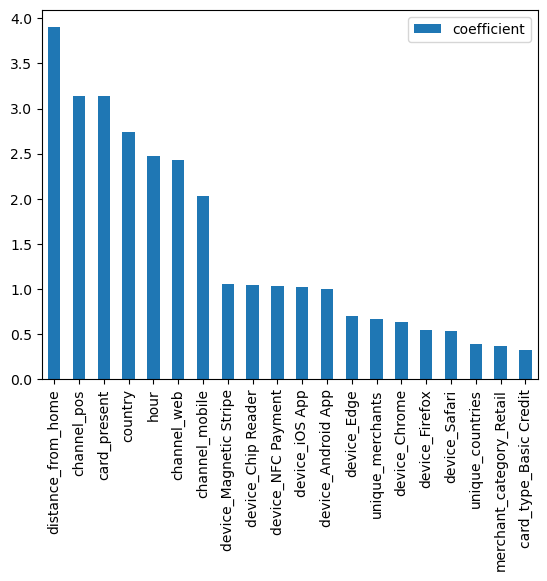

In [81]:
pd.DataFrame({'coefficient':model.coef_[0]}, index= feature_names).abs().sort_values('coefficient', ascending=False)[:20].plot.bar()

#### make predictions

In [84]:
X_test.head(2)

,merchant_category,merchant_type,merchant,country,city,city_size,card_type,card_present,device,channel,distance_from_home,high_risk_merchant,weekend_transaction,year,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
628886,Restaurant,0.068358,0.117815,0.260471,1.0,medium,Platinum Credit,0,Android App,mobile,0,0,0,0.0,1.0,0.034483,0.652174,0.118644,0.199702,0.227169,0.880435,1.0,0.704201,0.507789
3017013,Gas,0.199695,0.327128,0.122133,1.0,medium,Premium Debit,0,Chrome,web,0,0,1,0.0,1.0,0.379310,0.521739,0.728814,0.091654,0.059365,0.673913,0.5,0.191838,0.306115


In [85]:
X_test_enc.head(2)

,merchant_category_Education,merchant_category_Entertainment,merchant_category_Gas,merchant_category_Grocery,merchant_category_Healthcare,merchant_category_Restaurant,merchant_category_Retail,merchant_category_Travel,card_type_Basic Credit,card_type_Basic Debit,card_type_Gold Credit,card_type_Platinum Credit,card_type_Premium Debit,device_Android App,device_Chip Reader,device_Chrome,device_Edge,device_Firefox,device_Magnetic Stripe,device_NFC Payment,device_Safari,device_iOS App,channel_mobile,channel_pos,channel_web,city_size,merchant_type,merchant,country,city,card_present,distance_from_home,high_risk_merchant,weekend_transaction,year,month,day,hour,minute,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount,USD_converted_amt
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.068358,0.117815,0.260471,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.034483,0.652174,0.118644,0.199702,0.227169,0.880435,1.0,0.704201,0.507789
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.199695,0.327128,0.122133,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.379310,0.521739,0.728814,0.091654,0.059365,0.673913,0.5,0.191838,0.306115


In [86]:
def make_prediction(pred_set_x):
    pred_set_x= ct.transform(pred_set_x)
    # pred_set_x= sc.transform(pred_set_x)
    result= model.predict(pd.DataFrame(pred_set_x, columns=X_train_enc.columns))
    return result.astype('bool')
    # for pred in result:    
    #     if pred:
    #         print("Danger")
    #     else:
    #         print('ok ')

make_prediction(X_test[10:20])

array([False, False, False, False,  True, False, False, False, False,
       False])

In [87]:
make_prediction(X_test.sample(15))

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False])

pred_df= pd.DataFrame([['Healthcare',	3124,	812,	724949.27,	7143,	7143,	47401,	'medium',	'Basic Debit',	False,	'Chrome',	'web',	1,	1,	False,	0,	False]],
                       columns=X_train.columns)
pred_test_test_test_test_test_test_df

make_prediction(pred_df)

In [88]:
make_prediction(X_test[10:16])

array([False, False, False, False,  True, False])

In [97]:
y_test.values

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
import numpy as np
print(np.concatenate((y_test.values.reshape(-1,1), model.predict(X_test_enc).reshape(-1,1)) , axis= 1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


Make more predictions

In [53]:
stop here
made intentionally

SyntaxError: invalid syntax (3547097802.py, line 1)

#### The END

In [99]:
# frequency encoding
for col in freq_enc:
    freq= all_df[col][:1000].value_counts().to_dict()    
    print(col, " -> ", min(freq.values()))

merchant_type  ->  28
merchant  ->  1
country  ->  59
city  ->  5


In [ ]:
pred_df= pd.DataFrame([['Healthcare',	3124,	812,	724949.27,	7143,	7143,	47401,	'medium',	'Basic Debit',	False,	'Chrome',	'web',	1,	1,	False,	0,	False]],
                       columns=X_train.columns)
pred_df

make_prediction(pred_df)

array([ True])

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [229]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()
X1 = bal_df.drop('target', axis=1)
y1 = bal_df['target']

new_x_train, new_x_test, new_y_train, new_y_test = train_test_split(X1, y1, test_size=0.2)

log_clf.fit(new_x_train, new_y_train)
log_clf.score(new_x_train, new_y_train), log_clf.score(new_x_test, new_y_test)

(0.9861527471812143, 0.9860868433133938)

c:\Users\me\ML\ML2\ML3\project\heart-disease\v_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


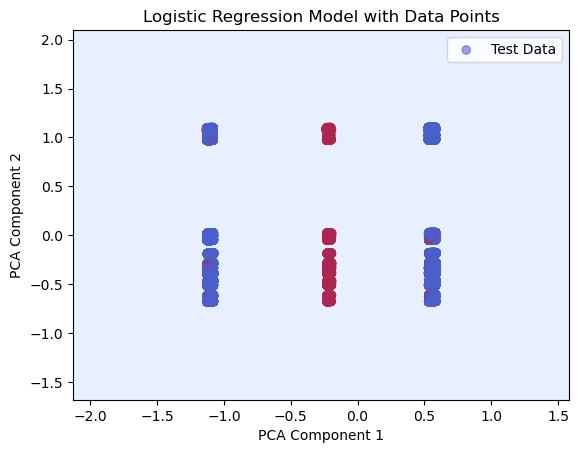

In [189]:
from sklearn.decomposition import PCA

# Reduce the dimensionality of the data to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train)
X_test_pca = pca.transform(x_test)

# Plot the training data points
# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.5, label='Train Data')

# Plot the test data points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', alpha=0.5, label='Test Data')

# Plot the decision boundary
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = log_clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Logistic Regression Model with Data Points')
plt.legend()
plt.show()

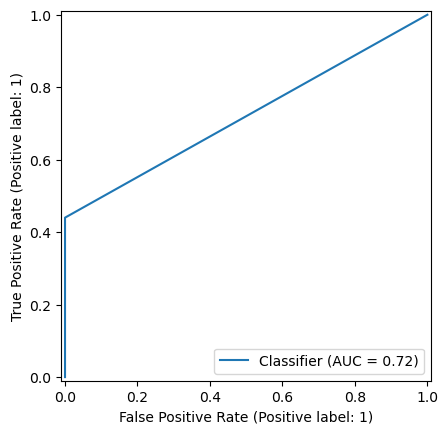

In [190]:
RocCurveDisplay.from_predictions(y_test,log_clf.predict(x_test))

##### compare model

In [104]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

def evaluate_model(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {
        'accuracy': round(accuracy, 2),
        'precision': round(precision, 2),
        'recall': round(recall, 2),
        'precision': round(precision, 2),
        'f1': round(f1, 2)
    }
    print(f'Acc: {accuracy*100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 score: {f1:.2f}')

    return metric_dict

Acc: 92.48%
Precision: 0.85
Recall: 0.76
F1 score: 0.80
Acc: 90.65%
Precision: 0.71
Recall: 0.91
F1 score: 0.80


<Axes: >

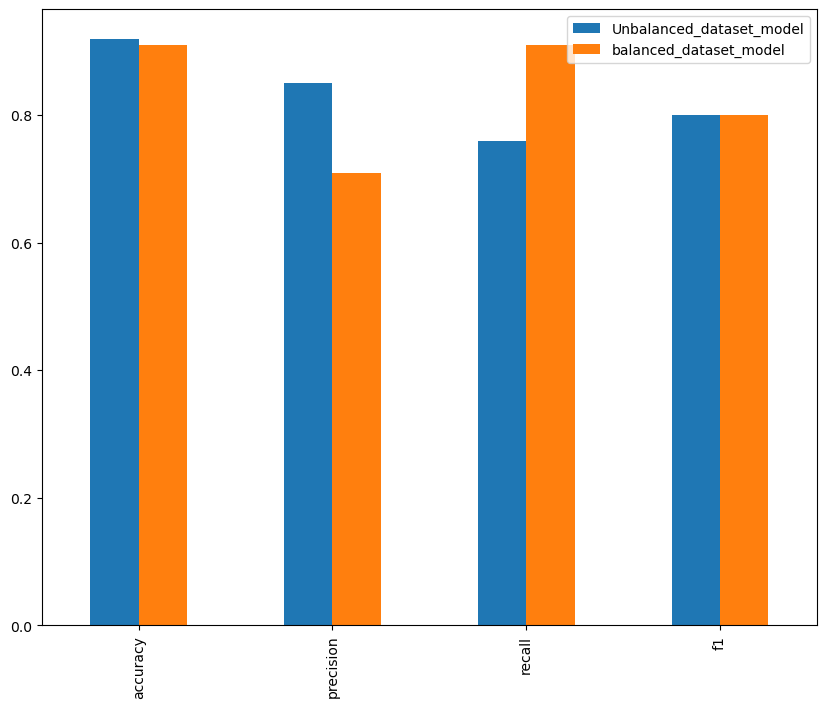

In [106]:
model_preds = model.predict(X_test_enc)
bal_model_preds = model_2.predict(X_test_enc)
model_metric = evaluate_model(y_test, model_preds)
bal_model_metric = evaluate_model(y_test, bal_model_preds)

compare_metric = pd.DataFrame({'Unbalanced_dataset_model': model_metric,
                              'balanced_dataset_model':bal_model_metric})

compare_metric.plot.bar(figsize=(10, 8))

##### Random Over Sample

In [110]:
from imblearn.over_sampling import RandomOverSampler

ros= RandomOverSampler()
bal_X_train_enc, bal_y_train=  ros.fit_resample(X_train_enc, y_train)

print(f'Percentage of Fraudulent Transaction : {bal_y_train.value_counts(normalize = True)[0] * 100}%')
print(f'Percentage of Normal Transaction : {bal_y_train.value_counts(normalize = True)[1] * 100}%')

Percentage of Fraudulent Transaction : 50.0%
Percentage of Normal Transaction : 50.0%


In [114]:
bal_model= LogisticRegression()
bal_model.fit(X_train_enc, y_train)
bal_model.score(bal_X_train_enc, bal_y_train), bal_model.score(X_test_enc, y_test)

(0.8622454101232566, 0.9248105900326484)

In [115]:
print(classification_report(y_test, model.predict(X_test_enc)))
print(classification_report(y_test, bal_model.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    359288
           1       0.85      0.76      0.80     89738

    accuracy                           0.92    449026
   macro avg       0.89      0.86      0.88    449026
weighted avg       0.92      0.92      0.92    449026

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    359288
           1       0.85      0.76      0.80     89738

    accuracy                           0.92    449026
   macro avg       0.89      0.86      0.88    449026
weighted avg       0.92      0.92      0.92    449026



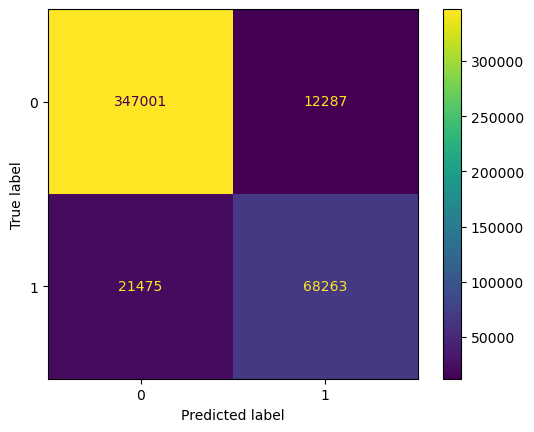

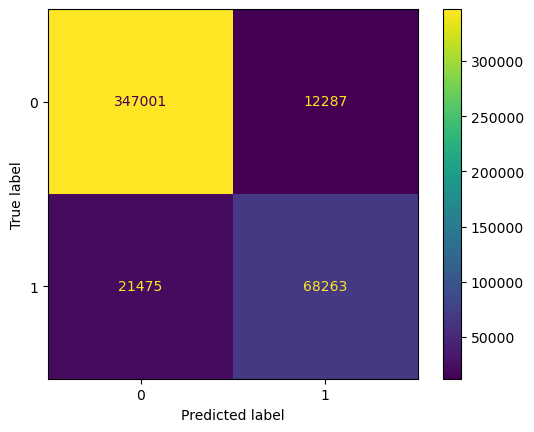

In [116]:
ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test_enc))
ConfusionMatrixDisplay.from_predictions(y_test, bal_model.predict(X_test_enc))

In [117]:
bal_model.score(X_train_enc, y_train), bal_model.score(X_test_enc, y_test)

(0.9329329706729863, 0.9248105900326484)

<Axes: >

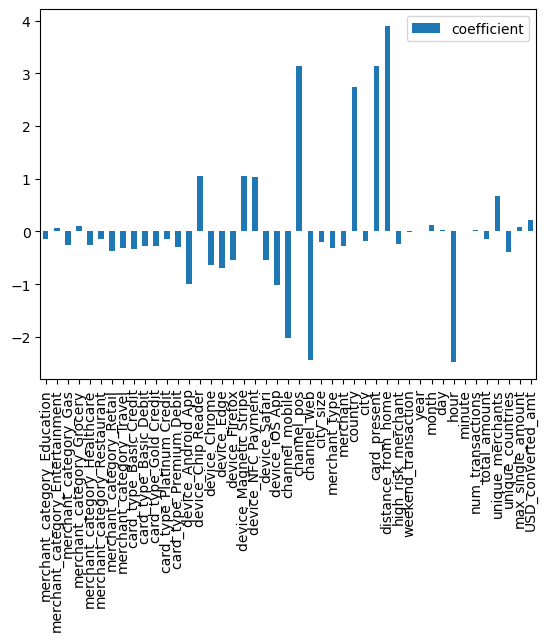

In [131]:
pd.DataFrame({'coefficient': bal_model.coef_[0]}, index=feature_names).plot.bar()

<Axes: >

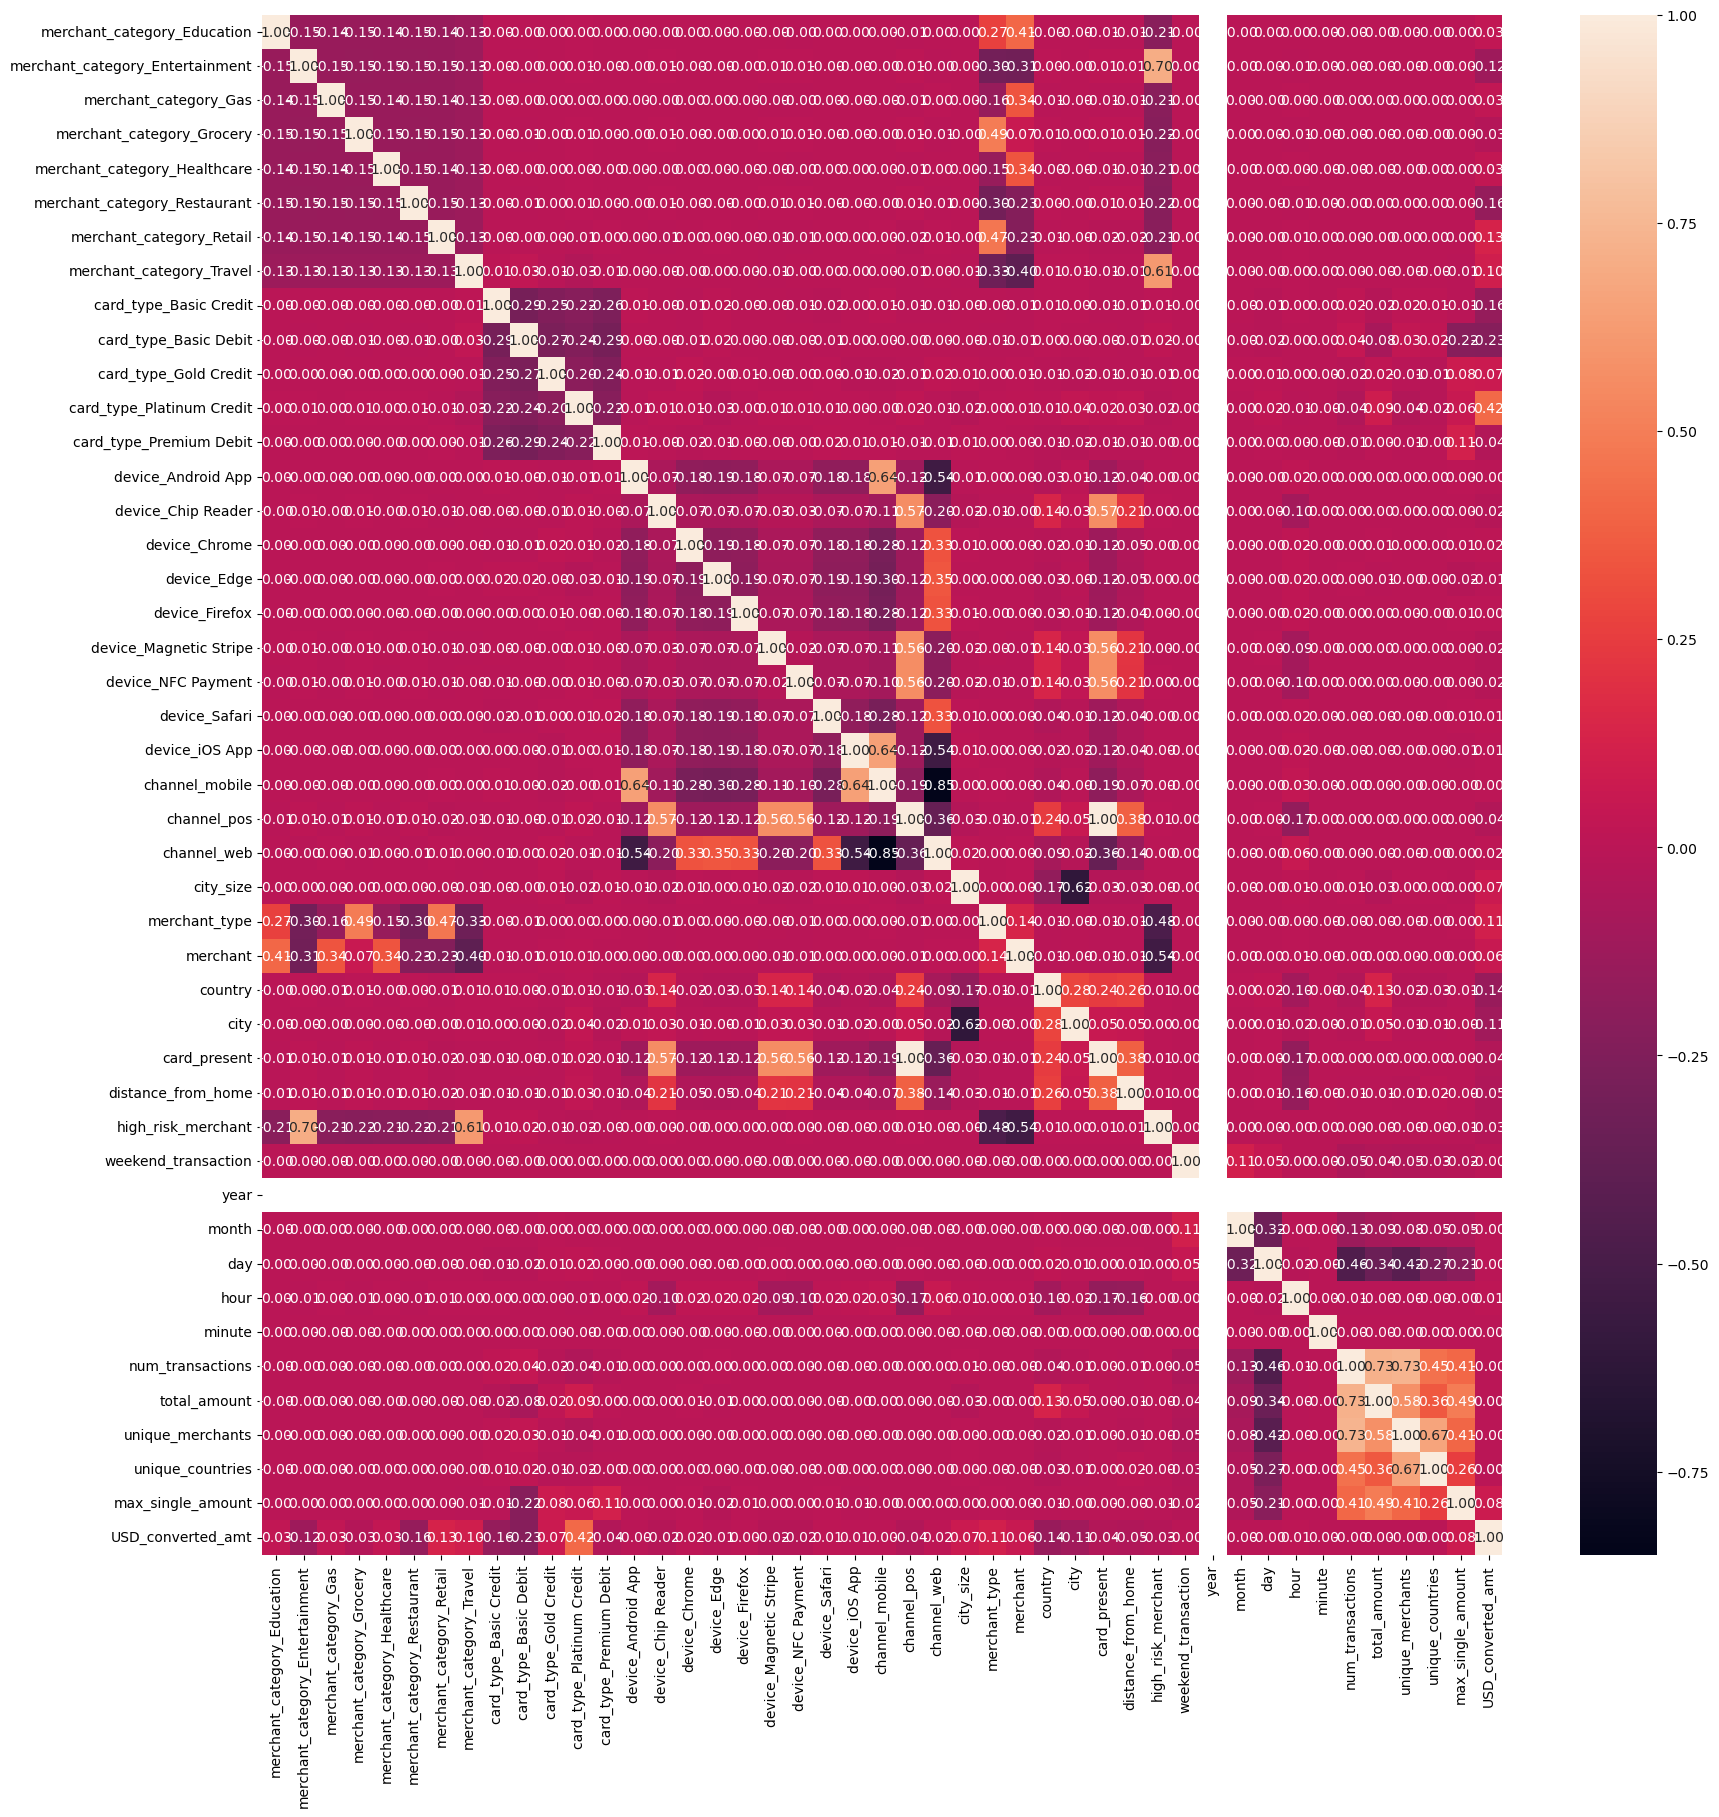

In [120]:
# Visualisation
plt.figure(figsize = (20, 20))
sns.heatmap(X_train_enc.corr(), annot=True, fmt='.2f')

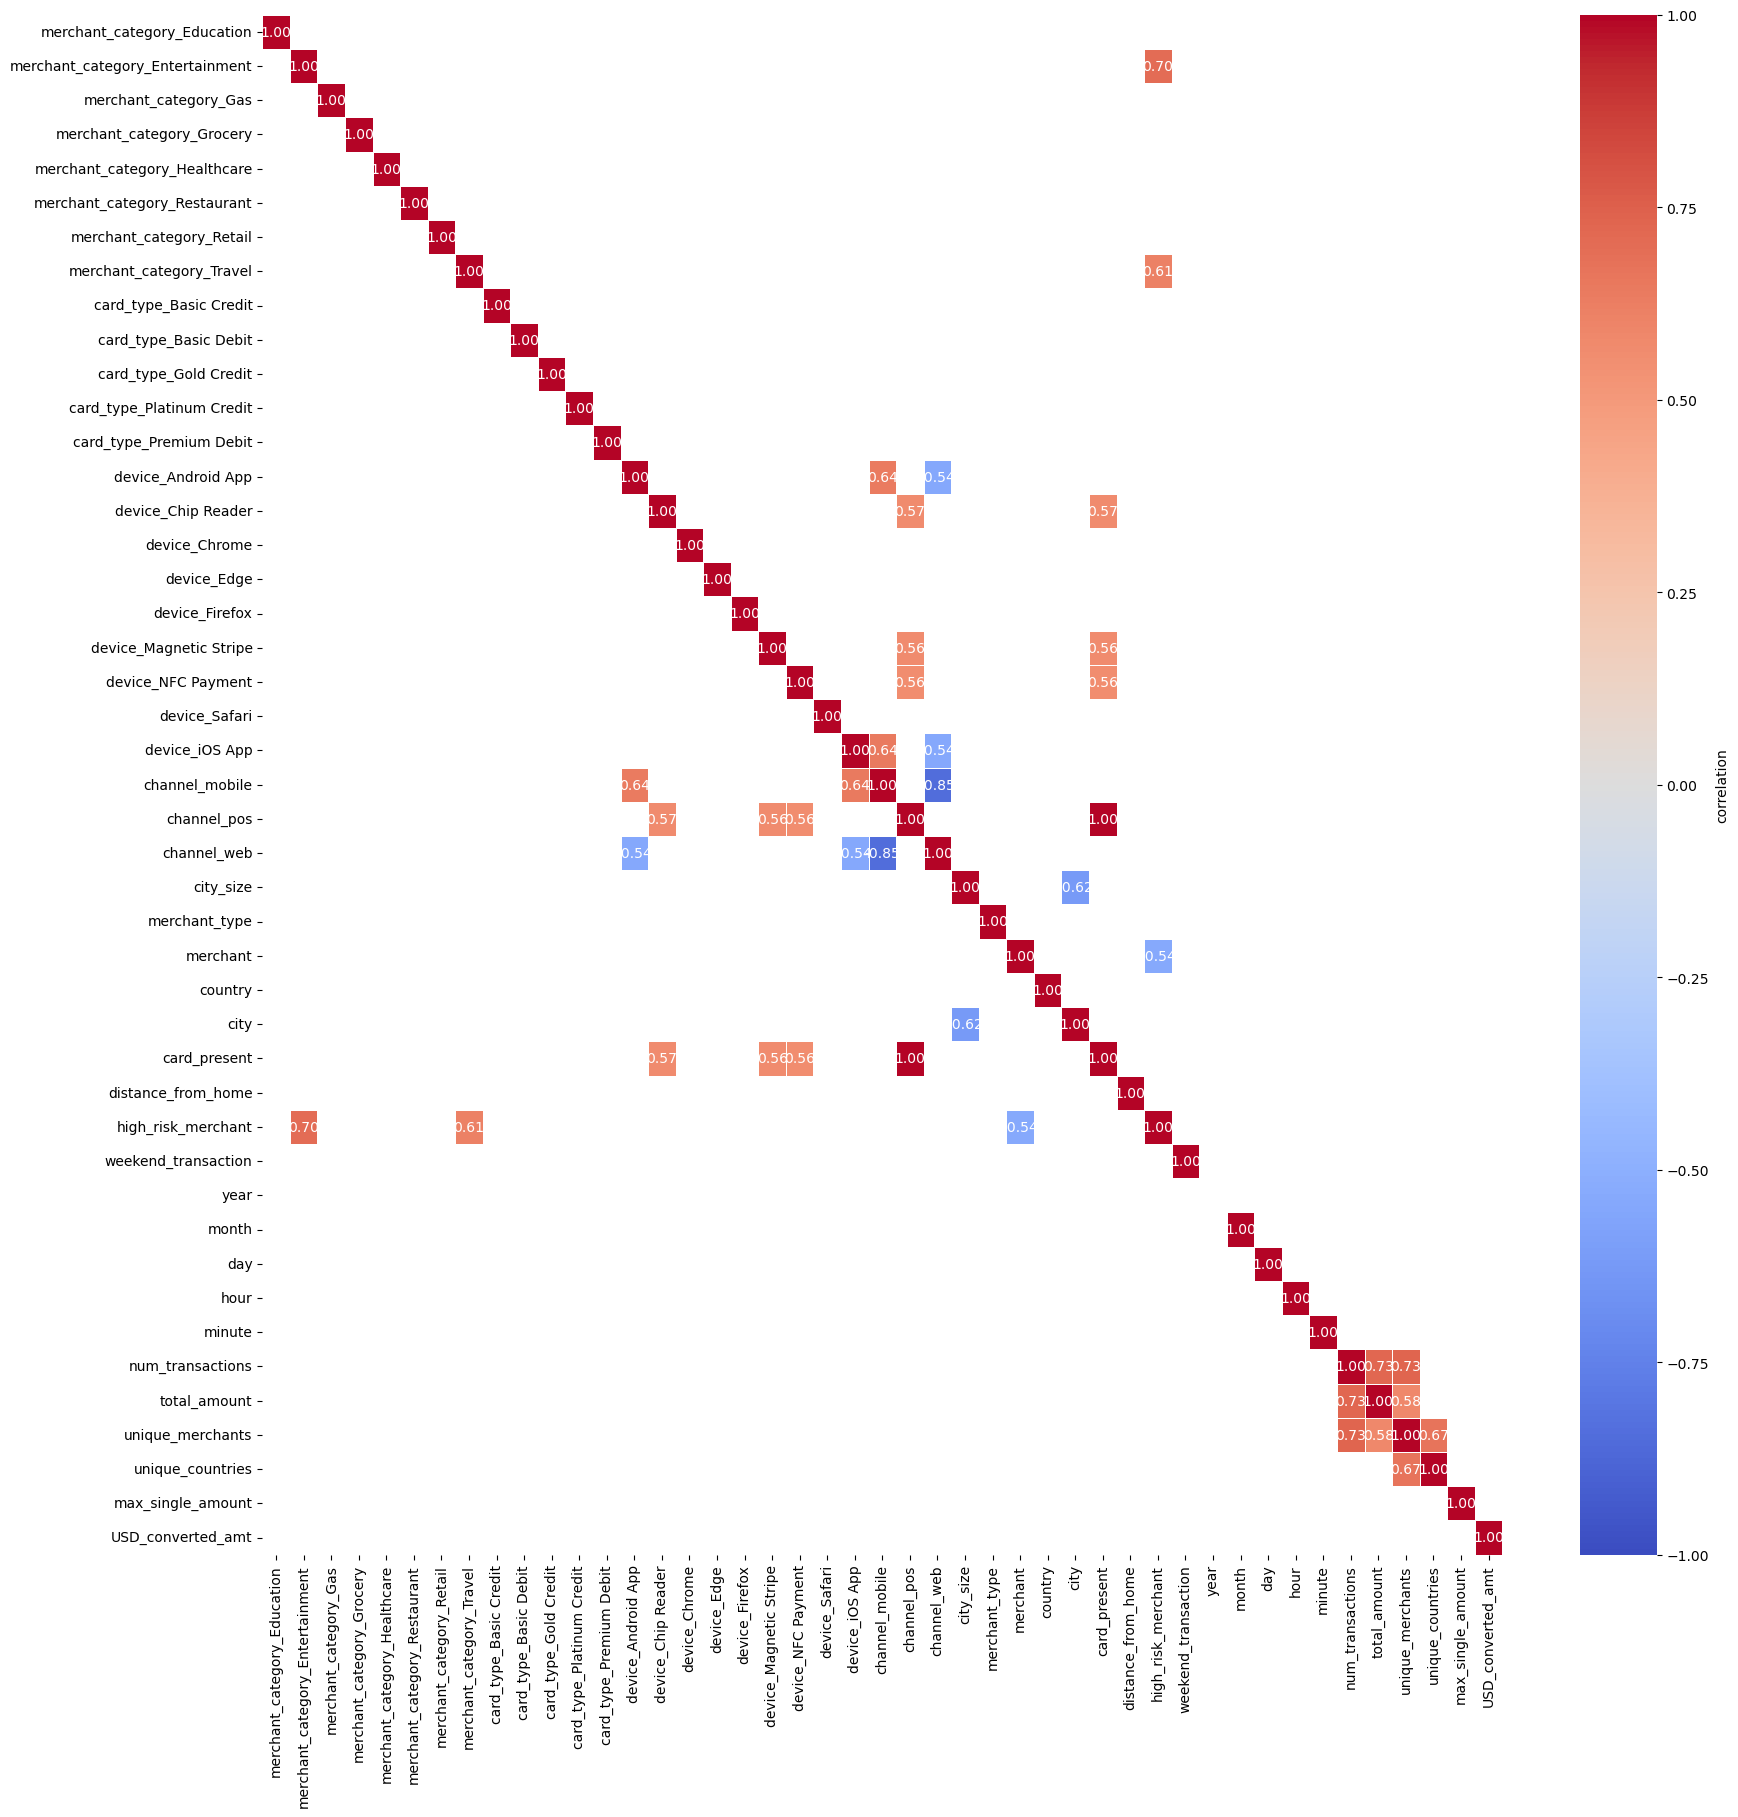

In [121]:
## Heatmap Creation to perform multivariate analysis
transaction_corr = X_train_enc.corr()

# Set up a threshold to limit uncorrelated values to be visible
threshold = 0.5

# Filter the possible correlations
filtered_corr = transaction_corr[abs(transaction_corr) >= 0.5]

# Visualisation
plt.figure(figsize = (20, 20))
sns.heatmap(filtered_corr, vmin = -1, vmax = 1, annot = True, fmt = '.2f', linewidth = 0.5, mask = filtered_corr.isnull(), 
           cmap = 'coolwarm', cbar_kws = {'label' : 'correlation'})
plt.show()

c:\Users\me\ML\ML2\ML3\project\heart-disease\v_env\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\me\ML\ML2\ML3\project\heart-disease\v_env\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

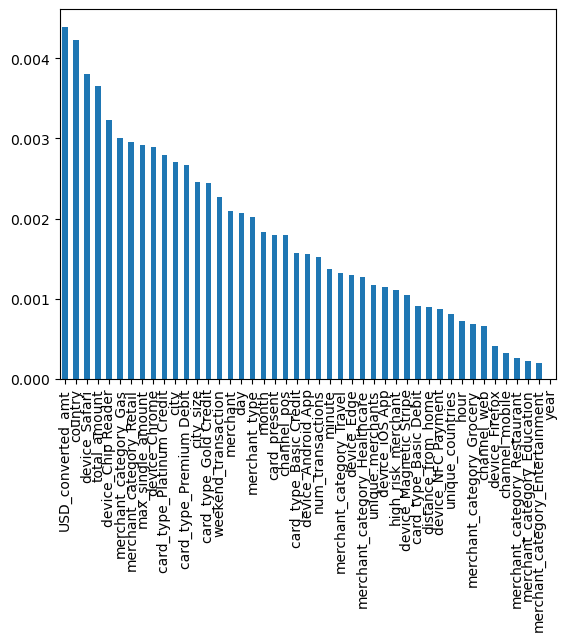

In [123]:
X_train_enc.corrwith(y_train).abs().sort_values(ascending=False).plot.bar()

c:\Users\me\ML\ML2\ML3\project\heart-disease\v_env\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\me\ML\ML2\ML3\project\heart-disease\v_env\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Axes: >

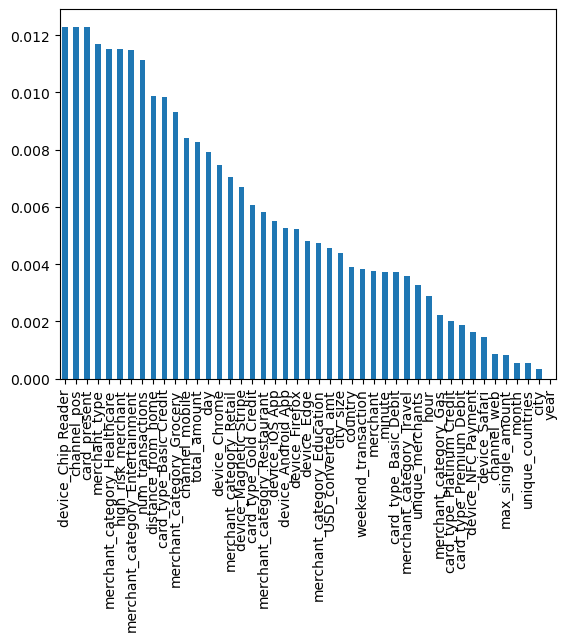

In [126]:
X_test_enc.corrwith(y_test).abs().sort_values(ascending=False).plot.bar()

##### training with important feature only

In [136]:
imp_features= pd.DataFrame({'coefficient':model.coef_[0]}, index= feature_names).abs().sort_values('coefficient', ascending=False)[:20].index
imp_features

Index(['distance_from_home', 'channel_pos', 'card_present', 'country', 'hour',
       'channel_web', 'channel_mobile', 'device_Magnetic Stripe',
       'device_Chip Reader', 'device_NFC Payment', 'device_iOS App',
       'device_Android App', 'device_Edge', 'unique_merchants',
       'device_Chrome', 'device_Firefox', 'device_Safari', 'unique_countries',
       'merchant_category_Retail', 'card_type_Basic Credit'],
      dtype='object')

In [137]:
# imp_features= X_train_enc.corrwith(y_train).abs().sort_values(ascending=False)[:20].keys()
imp_X_train= X_train_enc[imp_features] 
# also for X_test
imp_X_test= X_test_enc[imp_features] 

In [138]:
imp_model =LogisticRegression(class_weight='balanced')
imp_model.fit(imp_X_train, y_train)
imp_model.score(imp_X_train, y_train), imp_model.score(imp_X_test, y_test)

(0.9105063779746676, 0.9057270625754411)

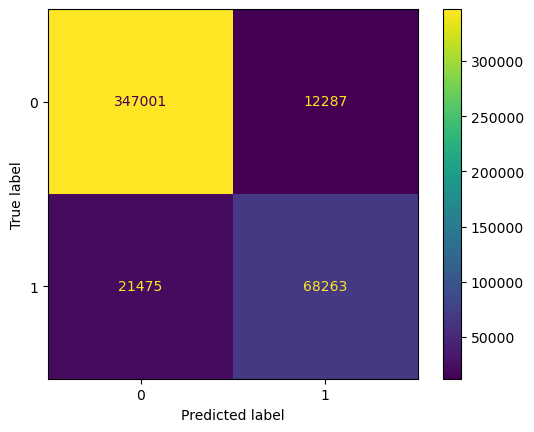

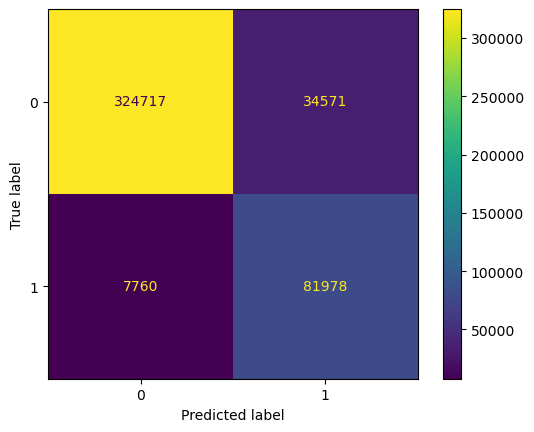

In [139]:
ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test_enc))).plot()
ConfusionMatrixDisplay(confusion_matrix(y_test, imp_model.predict(imp_X_test))).plot()

Acc: 92.48%
Precision: 0.85
Recall: 0.76
F1 score: 0.80
Acc: 90.57%
Precision: 0.70
Recall: 0.91
F1 score: 0.79


<Axes: >

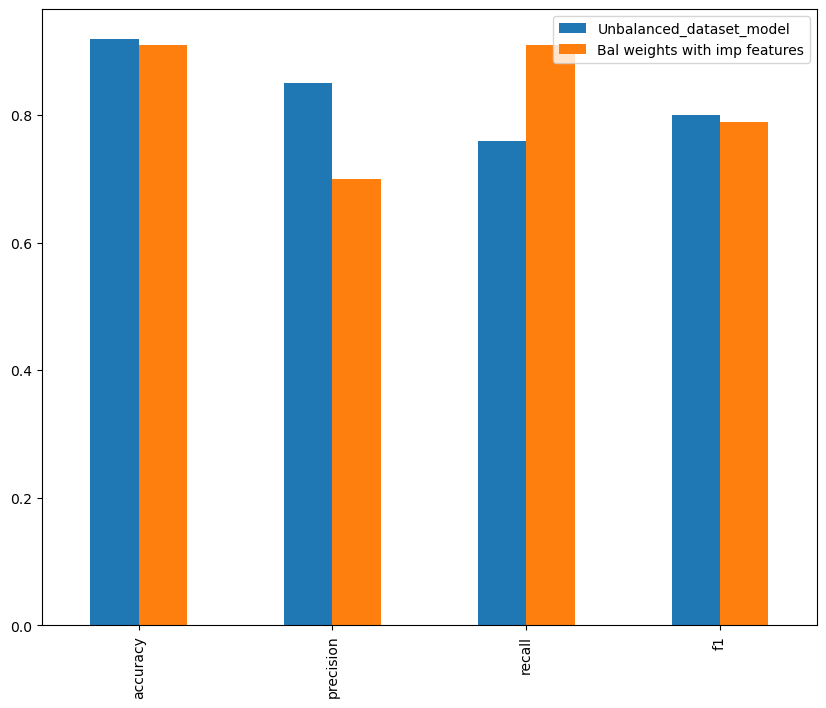

In [142]:
model_preds = model.predict(X_test_enc)
bal_model_preds = imp_model.predict(imp_X_test)
model_metric = evaluate_model(y_test, model_preds)
bal_model_metric = evaluate_model(y_test, bal_model_preds)

compare_metric = pd.DataFrame({'Unbalanced_dataset_model': model_metric,
                              'Bal weights with imp features':bal_model_metric})

compare_metric.plot.bar(figsize=(10, 8))

##### Standard vs MinMax vs Robust 

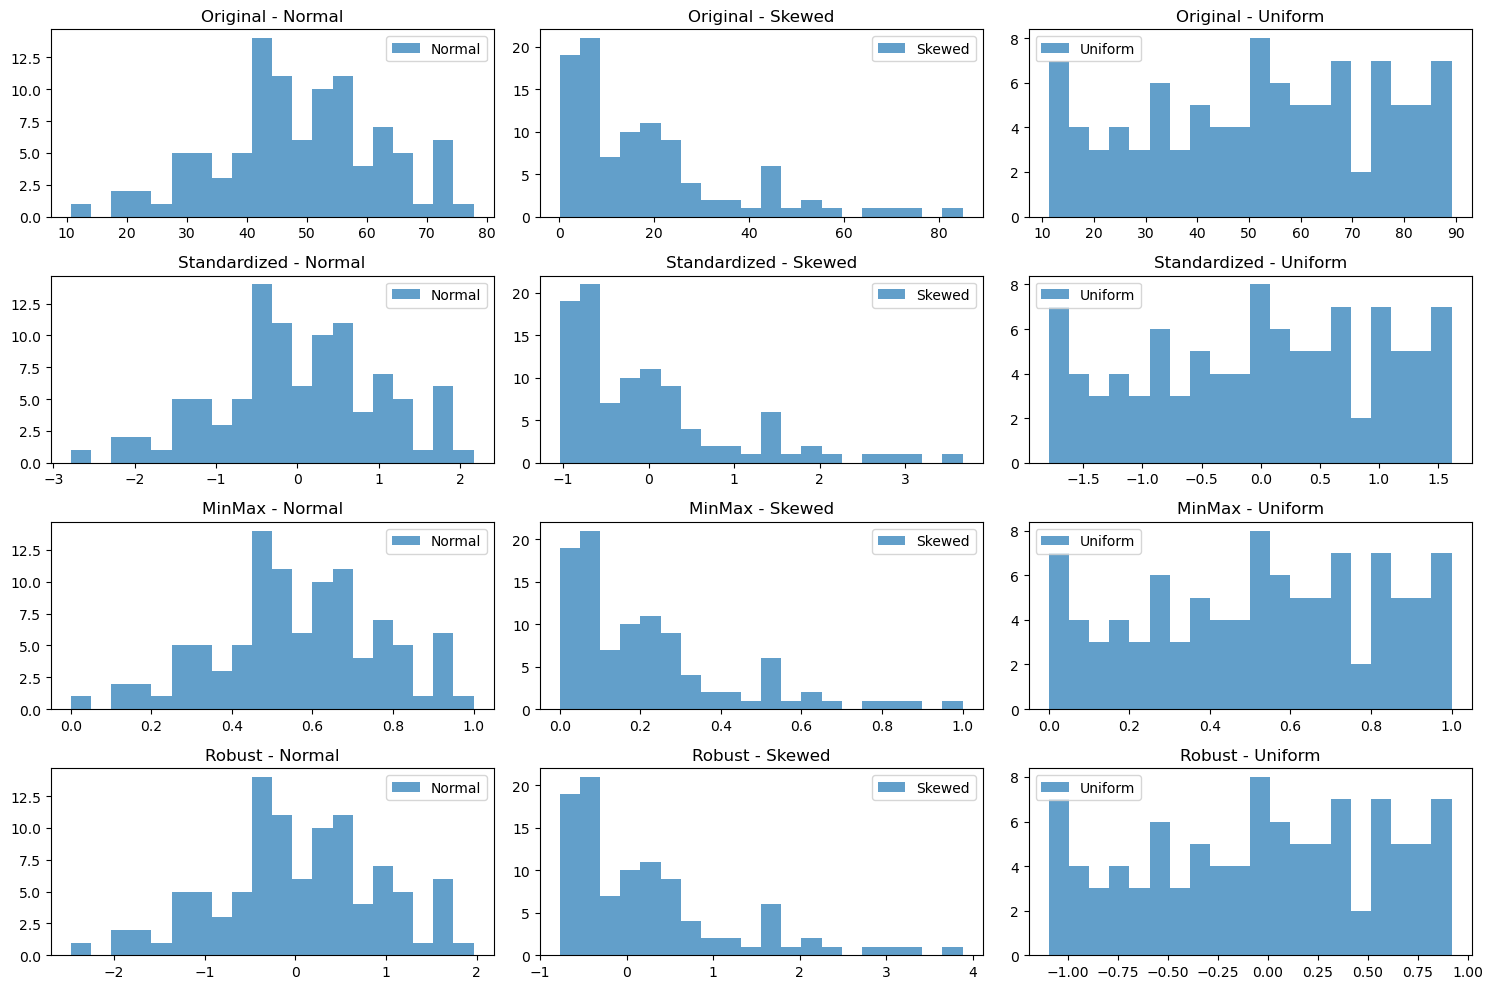

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Generate sample data (Normal, Skewed, and Uniform Distributions)
np.random.seed(42)
normal_data = np.random.normal(loc=50, scale=15, size=100)  # Normal Distribution
skewed_data = np.random.exponential(scale=20, size=100)      # Skewed Distribution
uniform_data = np.random.uniform(low=10, high=90, size=100)  # Uniform Distribution

# Combine into a DataFrame
test_df = pd.DataFrame({
    'Normal': normal_data,
    'Skewed': skewed_data,
    'Uniform': uniform_data
})

# Initialize Scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Apply Scaling
test_df_standardized = pd.DataFrame(standard_scaler.fit_transform(test_df), columns=test_df.columns)
test_df_minmax = pd.DataFrame(minmax_scaler.fit_transform(test_df), columns=test_df.columns)
test_df_robust = pd.DataFrame(robust_scaler.fit_transform(test_df), columns=test_df.columns)

# Plot Original vs. Scaled Data
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
scaling_methods = [('Original', test_df), ('Standardized', test_df_standardized), 
                   ('MinMax', test_df_minmax), ('Robust', test_df_robust)]

for i, (title, dataset) in enumerate(scaling_methods):
    for j, column in enumerate(dataset.columns):
        axes[i][j].hist(dataset[column], bins=20, alpha=0.7, label=column)
        axes[i][j].set_title(f"{title} - {column}")
        axes[i][j].legend()

plt.tight_layout()
plt.show()
